# DCBHs Low Gas Density
This file is a test case for producing DCBHs by simulating a low gas density in the halo. This drastically improves the effectiveness of Lyman-Werner photons. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
 %reload_ext autoreload

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from physics import definitions as phys

import matplotlib
# import integrators
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import quad_vec
from scipy.integrate import simpson

# import derivatives
from scipy.misc import derivative
# import interpolator
from scipy.interpolate import interp1d
# import system solver 
from scipy.optimize import fsolve

# import ODE solver
from scipy.integrate import solve_ivp

# import pandas for cosmic variance
import pandas as pd

# import h5py for large file management 
import h5py

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

from scipy.misc import derivative

In [4]:
# Run this for pretty graphs :)

import matplotlib
matplotlib.rc_file('matplotlibrc')

In [5]:
# Get the default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Print the colors
print(default_colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [6]:
# Import halo mod 
import hmf
import halomod
from halomod import TracerHaloModel

In [235]:
# Axion Decay rate (s^-1)
def gamma_decay(ma,ga):
    """
    ma - eV
    ga - GeV^(-1)
    output - decay rate s^(-1)
    """
    return (ma*1e-9)**3 * ga**2 *phys.GeV_To_InvSec/(64*np.pi)

# A list containing Hydrogen n>=3 levels
H_levels = phys.lyman_np_level(np.arange(3,25))


In [236]:
# Function to calculate closest near H lyman line 
def closest_below(arr, val):
    """
    Function that inputs a list 'arr' and a value 'val' and outputs the largest value smaller than val in the list.
    
    """
    arr = np.asarray(arr)
    val = np.asarray(val)
    
    # Create an output array of the same shape as val to store results
    result = np.full_like(val, np.nan, dtype=float)
    
    for i, v in np.ndenumerate(val):
        # Filter arr to include only elements smaller than the given number
        smaller_elements = arr[arr < v]
        
        # If there are elements smaller than the number, get the maximum element
        if smaller_elements.size > 0:
            result[i] = smaller_elements.max()
    
    return result

# II. Toy Halo Model 

In this section of the code, we describe a toy halo model. This includes behavior of dark matter, baryons, and temperature evolution in the standard picture.

We first begin with behavior of dark matter. In this case, we use Mass Accretion Histories, based on Extended Press-Schechter, described in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398). The mass of a halo at any redshift may be written as:
$$
M_H (z) = M_0 (1+z)^{a f(M_0)} \exp{(f(M_0)z)} \ .
$$
Here, $M_0 \equiv M_\text{Halo}(z=0)$ is the only free parameter. The cosmology is encoded in $a$ and $f(M_0)$ via the growth factor $D(z)$, and the variance of the cosmic density field $\sigma(M)$ today (see eq.19-23 in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398)).

Here, the cosmology is accordance to Planck 2018 parameters.


## 1. Dark Matter

First, we need to generate the variance of the cosmic density field using HaloMode code, and using Planck 2018 parameters. 

In [17]:
# Import constructor
from halomod import TracerHaloModel

In [18]:
hm = TracerHaloModel(

    # Halo growth model
    hmf_model = 'PS', 
    
    # Window function model 
    filter_model="TopHat",
    
    # background cosmology parameters from Planck 2018
    cosmo_params={
        "Om0": phys.Omega_m,   # total matter density
        "Ob0": phys.Omega_b,   # baryon density
        "H0": 100 * phys.h,    # H0 must be in km/s/Mpc
    },
    # these are transfer / power spectrum parameters
    sigma_8=0.811,
    n=0.965, 

    # Set minimum cutoff length scale 
    Mmin = -9, # Minimum mass fluctuation in log10(M)
    Mmax = 15, # Maximum mass fluctuation in log10(M)
    dlog10m = 0.01, # Log bin spacing between the mass

    # Define transfer function parameters for matter power spectrum}
    transfer_params = {'extrapolate_with_eh': True, 'kmax':1e2}
)

In [19]:
hm.parameter_values

{'bias_model': halomod.bias.Tinker10,
 'bias_params': {},
 'cosmo_model': FlatLambdaCDM(name='Planck18', H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.30966, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.04897),
 'cosmo_params': {'Om0': 0.3134658225396014,
  'Ob0': 0.049309230511847414,
  'H0': 67.4},
 'n': 0.965,
 'sigma_8': 0.811,
 'growth_params': {},
 'lnk_min': np.float64(-18.420680743952367),
 'lnk_max': np.float64(9.903487552536127),
 'dlnk': 0.05,
 'z': 0.0,
 'transfer_model': hmf.density_field.transfer_models.CAMB,
 'transfer_params': {'extrapolate_with_eh': True, 'kmax': 100.0},
 'takahashi': True,
 'growth_model': hmf.cosmology.growth_factor.GrowthFactor,
 'hmf_model': hmf.mass_function.fitting_functions.PS,
 'Mmin': -9,
 'Mmax': 15,
 'dlog10m': 0.01,
 'mdef_model': None,
 'mdef_params': {},
 'delta_c': 1.686,
 'hmf_params': {},
 'filter_model': hmf.density_field.filters.TopHat,
 'filter_params': {},
 'disable_mass_conversion': True,
 'halo_pr

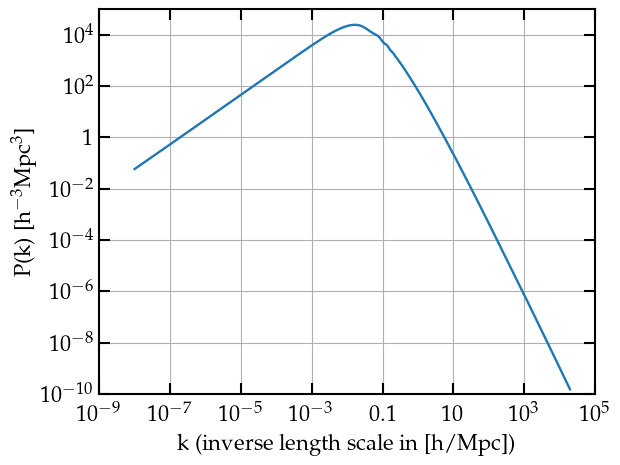

In [20]:
# Plot Cosmic density field 
plt.figure(figsize=(6.4,5))
plt.loglog()

plt.plot(hm.k, hm.power)

plt.xlabel(r'k (inverse length scale in [h/Mpc])')
plt.ylabel(r'P(k) [h$^{-3}$Mpc$^{3}$]')

plt.xlim(1e-9, 1e+5)
plt.ylim(1e-10,1e+5)

plt.grid()

plt.show()

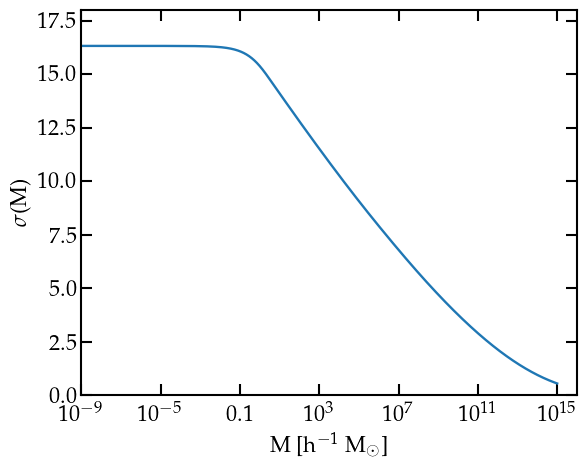

In [21]:
# Plot Variance of cosmic density field 
plt.figure(figsize=(6.4,5))

plt.plot(hm.m, hm.sigma)

plt.xlim(1e-9, 1e+16)
plt.ylim(0, 18)

plt.xlabel(r'M [h$^{-1}$ M$_\odot$]')
plt.ylabel(r'$\sigma$(M)')

plt.xscale('log')

In [22]:
# Save cosmic variance in an interpolating function 
cosmic_variance = interp1d(hm.m/phys.h, hm.sigma, kind='linear')

In [23]:
# Calculate the derivative of growth factor from HaloMode
hm.growth_factor

np.float64(1.0)

Checking derivative of the growth factor
$$
    \left. \frac{d D(z)}{dz} \right|_{z=0}
$$

In [24]:
# Calculate Derivative of growth factor using HaloMod 
eps = 1e-4

hm.update(z=eps)
d1 = hm.growth_factor
hm.update(z=0)
d2 = hm.growth_factor

d_growth_0 = (d1 - d2)/eps

print(f'dD/dz (z=0) from HaloMod:{d_growth_0:.3e}')

# update hm parameter to z=0 again for safety 
hm.update(z=0)

dD/dz (z=0) from HaloMod:-5.274e-01


In [25]:
# Calculate the derivative of growth factor using Carrol 1992 approximation
# eq. 4.76 in the MBW galaxy book 
d_growth_1 = derivative(phys.growth_fac, 0, dx=1e-5)
print(f'dD/dz (z=0) from MBW:{d_growth_1:.3e}')

dD/dz (z=0) from MBW:-5.127e-01


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/1794472287.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d_growth_1 = derivative(phys.growth_fac, 0, dx=1e-5)


In [26]:
# Calculate growth factor by doing the integral explicitly 
# Define function for integration in growth factor 
def D_integral (z): 

    val_1 = 1+z 
    val_2 = phys.Hubble(z) / phys.H0 
    return val_1 / val_2**3 

# Define function for growth factor and take the derivative
def growth_fac(z): 

    # Calculate normalization 
    norm,error = quad(D_integral, 0, np.inf)

    # Calculate value in the numerator 
    val,error = quad(D_integral, z, np.inf)

    # Normalized Hubble
    hubble = phys.Hubble(z) / phys.H0 

    return hubble * val / norm 

print(f'dD/dz (z=0) by computing explicit integral:{derivative (growth_fac, 0, dx=1e-5):.3e}')

dD/dz (z=0) by computing explicit integral:-5.257e-01


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/3952662029.py:23: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  print(f'dD/dz (z=0) by computing explicit integral:{derivative (growth_fac, 0, dx=1e-5):.3e}')


In [27]:
"""
Define parameters from Correa 2015.
Growth factor is defined in definitions file.

For now I am using the growth factor calculated from HaloMod 
"""

afac = d_growth_0*1.686*(2/np.pi)**0.5 + 1

def zfac(m0):
    return -0.0064*np.log10(m0)**2 + 0.0237*np.log10(m0) + 1.8837

def qfac(zf):
    return 4.137*zf**(-0.9476)

def ffac(m0):
    n1 = zfac(m0)
    n2 = qfac(n1)

    val1 = cosmic_variance(m0/n2)
    val2 = cosmic_variance(m0)

    return (val1**2 - val2**2)**(-1/2)


In [29]:
# With the parameters defined now define mass accretion histories

def MAH(M0 , z):
    return M0 * (1+z)**(afac*ffac(M0)) * np.exp(-ffac(M0)*z)

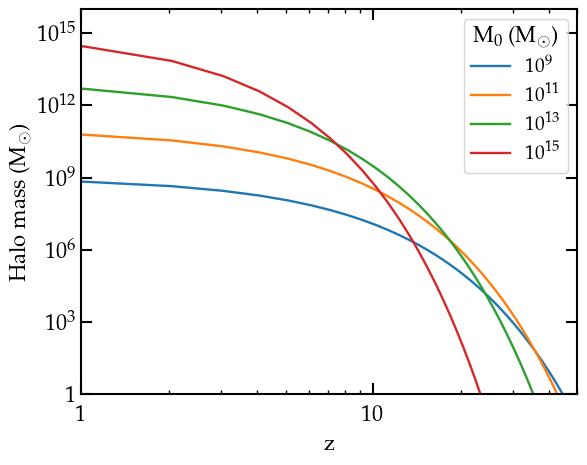

In [30]:
# Plot Mass Accretion History with different M0 
z_list=np.linspace(0,50) 

plt.figure(figsize=(6.4,5))
plt.loglog()

plt.plot(z_list, MAH(1e+9, z_list) , label=r'10$^9$' )
plt.plot(z_list, MAH(1e+11, z_list) , label=r'10$^{11}$')
plt.plot(z_list, MAH(1e+13, z_list) , label=r'10$^{13}$')
plt.plot(z_list, MAH(1e+15, z_list) , label=r'10$^{15}$')

plt.ylim(1,1e+16)
plt.xlim(1,50)
plt.legend(title=r'M$_0$ (M$_\odot$)')
plt.xlabel('z')
plt.ylabel(r'Halo mass (M$_\odot$)')

plt.show()

In [31]:
# M_0 that reaches 10^4 K at z=10
print(f'Halo virial temperature with EH parameterization: {phys.Tvir(10, MAH(5e+9, 10)):.3e} (K)')

Halo virial temperature with EH parameterization: 1.003e+04 (K)


In [32]:
print(f'{MAH(1e+12, 15):.2e}')

3.84e+07


In [33]:
3.5 * (15/11)**3

8.874906085649885

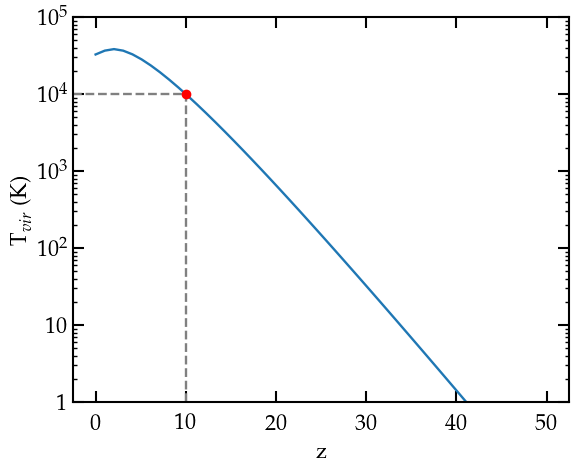

In [34]:
# Example data
z_list = np.linspace(0, 50)

plt.figure(figsize=(6.4,5))

plt.plot(z_list, phys.Tvir(z_list, MAH(5e+9, z_list)))

# Axis settings first
plt.yscale('log')
plt.ylim(1, 1e5)
plt.xlabel('z')
plt.ylabel(r'T$_{vir}$ (K)')

# Coordinates to mark
z0 = 10
T0 = 1e4

# Compute normalized coordinates
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

y_frac = (np.log10(T0) - np.log10(ymin)) / (np.log10(ymax) - np.log10(ymin))
x_frac = (z0 - xmin) / (xmax - xmin)

# Grey cross from axes to the point
plt.axvline(x=z0, ymax=y_frac, color='grey', linestyle='--')
plt.axhline(y=T0, xmax=x_frac, color='grey', linestyle='--')

# Marker at the point
plt.plot(z0, T0, 'o', color='red')

plt.show()

In [35]:
# Define fiducial halo parameter
m0_base=5e+9

In [36]:
def dMdz(z, m0): 
    delta_z = 1e-4
    d1 = MAH(m0, z)
    d2 = MAH(m0, z+delta_z)

    return (d1 - d2) / delta_z

## 3. Baryons 

The density evolution of baryons in halos is goverened by Jeans/filtering mass criteria if there are no extra cooling or heating terms. The filtering mass can be written as (with no streaming velocity) [Hegde 2023](https://inspirehep.net/literature/2650114)
$$
 M_F = 1.66 \times 10^4 \left(\frac{1 + z}{21} \right)^{0.85} \ M_\odot
$$

In [45]:
def filter_mass(z):
    return 1.66e+4 * ((1+z)/21)**(0.85)

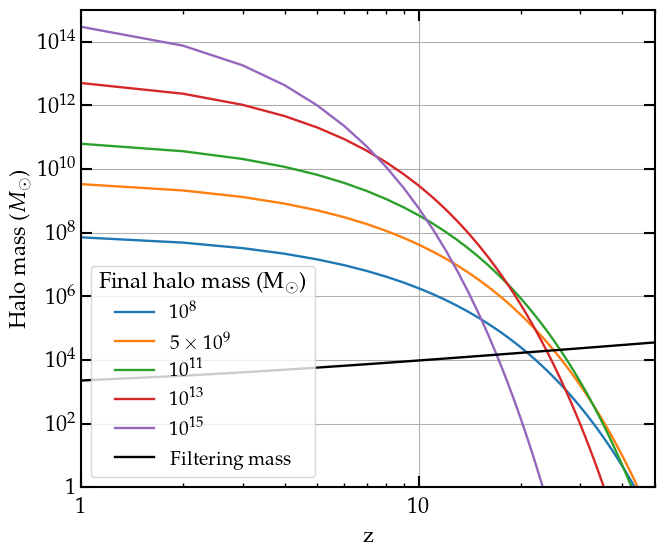

In [46]:
# Plot histories for a few final halo masses: 1e+9, 1e+11.5, 1e+14
z_list=np.arange(0,101)

plt.figure(figsize=(7.4, 6.2))

plt.plot(z_list, MAH(1e+8,z_list), label=r'$10^{8}$')
plt.plot(z_list, MAH(5e+9,z_list), label=r'$5\times10^{9}$')
plt.plot(z_list, MAH(1e+11,z_list), label=r'$10^{11}$')
plt.plot(z_list, MAH(1e+13,z_list), label=r'$10^{13}$')
plt.plot(z_list, MAH(1e+15,z_list), label=r'$10^{15}$')
plt.plot(z_list, filter_mass(z_list), label='Filtering mass', color='black')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'Halo mass ($M_\odot$)')
plt.xlim(1,50)
plt.ylim(1,1e+15)
plt.grid()
plt.legend(title = r'Final halo mass (M$_\odot$)')

plt.savefig('./plots/MAH.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [47]:
def zvir(M0):
    return fsolve(lambda z: MAH(M0, z) - filter_mass(z), 10)

In [48]:
print(f'Virialization redshift for fiducial halo is, zvir = {zvir(5e+9)[0]:.2e}.')

Virialization redshift for fiducial halo is, zvir = 2.51e+01.


In [49]:
z0_vir = zvir(m0_base)

In [50]:
print(f'The mass of the halo at zvir = {z0_vir[0]:.1f} is M_halo = {MAH(m0_base,z0_vir)[0]:.2e}.')

The mass of the halo at zvir = 25.1 is M_halo = 2.00e+04.


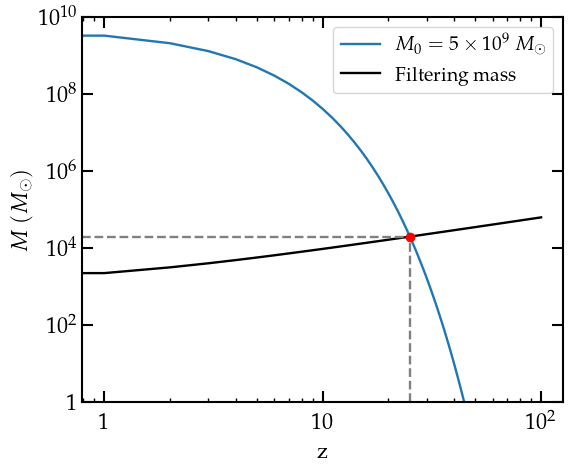

In [51]:
# Plot MAH and filter threshold for fiducial m0_base
plt.figure(figsize=(6.2,5))
plt.loglog()

plt.plot(z_list, MAH(m0_base, z_list), label=r'$M_0 = 5 \times 10^9 \ M_\odot$')
plt.plot(z_list, filter_mass(z_list), label='Filtering mass', color='black')

plt.ylim(1,1e+10)

# Point to mark
z_cross = 25.07
M_cross = 1.998168e4

# Current axis limits
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# Normalized coordinates in log space
x_frac = (np.log10(z_cross) - np.log10(xmin)) / (np.log10(xmax) - np.log10(xmin))
y_frac = (np.log10(M_cross) - np.log10(ymin)) / (np.log10(ymax) - np.log10(ymin))

# Grey cross from axes to the point
plt.axvline(x=z_cross, ymax=y_frac, color='grey', linestyle='--')
plt.axhline(y=M_cross, xmax=x_frac, color='grey', linestyle='--')

# Red marker at the point
plt.plot(z_cross, M_cross, 'o', color='red')

plt.legend()
plt.xlabel("z")
plt.ylabel(r"$M \ (M_\odot)$")
plt.show()

## 4. Density evolution

The density evolution is modeled according to simulations of [Visbal 2014](https://academic.oup.com/mnrasl/article/442/1/L100/955995), and semi-analytical formalisms of [Nebrin 2023](https://arxiv.org/pdf/2303.08024) and [Hegde 2023](https://arxiv.org/pdf/2304.03358).  Unfortunately, there isn't a simple way to get a continuous evolution from $z = z_{vir}$ to atomic cooling halos reaching the threshold at $z=10$. 

To model the density in close approximation to simulations and formation redshifts, we will use
$$
    n_{H} (z) = 
    \begin{cases}
    n_{H,IGM}(z) & \text{for }z > z_{vir} \\ 
    n_{H,small} (z) \propto T_{vir}^{3/2} & \text{for } z <= z_{vir} \text{ and } n_H < 3.5 \ \text{cm}^{-3} \\ 
    n_{H_,large} (z) = \text{constant} & \text{for } z <= z_{vir} \text{ and } n_H >= 3.5 \ \text{cm}^{-3}
    \end{cases}
$$

Here, $n_{H,small}$ and $n_{H,large}$ are densities in small and large halos as modeled by simulations. 

To create a smooth and differentiable density profile, we piece them together using a quintic smoothstep function.


In [68]:
# Define a base halo model. 
def nH_Halo (m0, z):

    """
    k - parameter to sigmoid function
    m0 - final halo mass 

    returns H number density [cm^3 s^(-1)]
    """

    m0 = np.asarray(m0)
    z = np.asarray(z)

    # Calculate redshift of virialization
    z_vir = zvir(m0)
    k=1.5

    # Define sigmoid of x
    sigmoid_x = 1 / (1 + np.exp(- k * (z - z_vir) ))

    # z > zvir
    val_1 = phys.nH0*(1+z)**3

    # z <= zvir
    val_2 = 1.2 * MAH(m0,z_vir)/(1e+6) * (( 1+z_vir ) / 10)**(3/2)

    return (sigmoid_x)*val_1 + (1 - sigmoid_x)*val_2


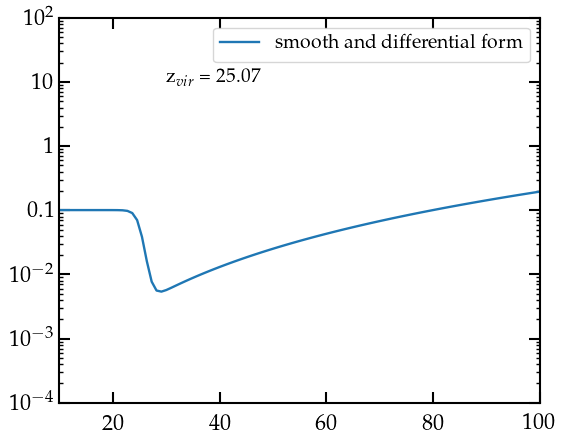

In [69]:
z_list =np.linspace(10,100,100)
plt.figure(figsize=(6.2,5))

plt.plot(z_list, nH_Halo( m0_base, z_list), label='smooth and differential form')
#plt.plot(z_list, nH_halo_hard(z_list),linestyle='dashed', label='hard piecewise')

# Tegmark model 
#plt.plot(z_list, nH_Tegmark(z_list), label='spherical collapse')

plt.text(30, 10, r'z$_{vir}$ = 25.07',fontsize=14) 

plt.xlim(10,100)
plt.ylim(1e-4,100)
plt.legend()

plt.yscale('log')

## 5. Temperature evolution

Since, there are no processes changing temperature of baryonic gas, except changes in H2 chemistry, we can model the temperature in a similar way to number density evolution i.e.

$$ 
 T_{halo} (z) \approx T_{IGM} \ , \ \text{for } z \gtrsim z_{vir}
$$
and
$$ 
T_{halo} (z) \approx T_{vir} \ , \text{for } z \lesssim z_{vir} \ .
$$

In [73]:
# Define a base temperature function 

def T_halo (m0, z): 

    """
    k - parameter to sigmoid function
    m0 - final halo mass
    """

    z = np.asarray(z)

    # Find zvir
    z_vir = zvir(m0)
    S_igm = smootherstep(z, z_vir-0.5, z_vir+0.5) 
        
    # z >> zvir
    temp_1 = phys.T_IGM(z)

    # z <= zvir 
    temp_2 = phys.Tvir(z, MAH(m0, z))

    temp = temp_1 * S_igm + (1 - S_igm) * temp_2
    return temp 

In [74]:

for m0 in np.array([5e+9, 1e+11, 5e+12]): 
    print(f'zvir = {zvir(m0)[0]:.2f}')

zvir = 25.07
zvir = 26.20
zvir = 24.56


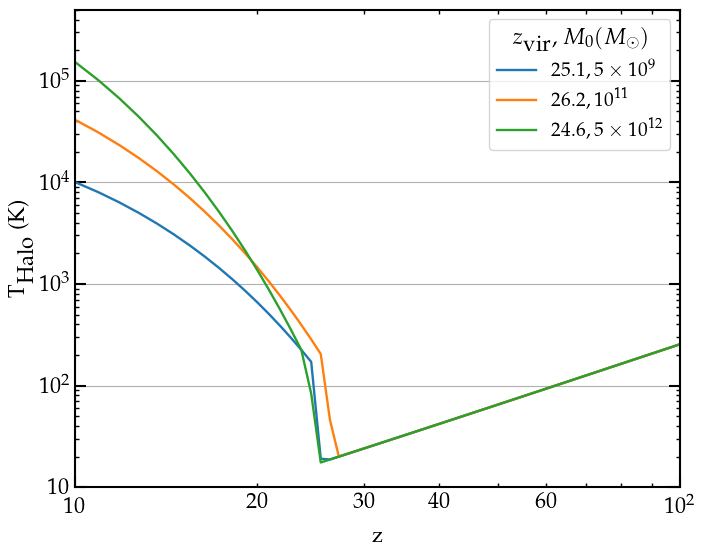

In [75]:
## Plot T_halo(z) for k = 1, and different zvir
z_list =np.linspace(10,100,100)
plt.figure(figsize=(7.8, 6.2))

plt.plot(z_list, T_halo(5e+9, z_list), label = r'25.1, $5 \times 10^{9}$')
plt.plot(z_list, T_halo(1e+11, z_list), label = r'26.2, $10^{11}$')
plt.plot(z_list, T_halo(5e+12, z_list), label = r'24.6, $5 \times 10^{12}$')

# Plot atomic cooling limit 
# plt.plot(z_list, T_atom, color='red', linewidth=2)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel(r'T$_{\textnormal{Halo}}$ (K)')

plt.ylim(1e+1, 5e+5)
plt.xlim(10,1e+2)

plt.legend(title = r'$z_{\textnormal{vir}}$, $M_0 (M_\odot)$')

# Save figure 
plt.savefig('./plots/temp.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

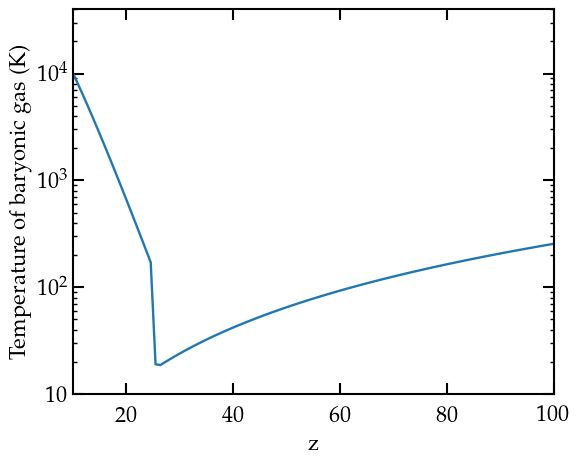

In [76]:
# Temperature evolution of the fiducial Halo Model 
plt.figure(figsize=(6.2,5))

plt.plot(z_list, T_halo(5e+9, z_list) )


plt.xlim(10,100)
plt.ylim(10,4e+4)

plt.xlabel('z')
plt.ylabel('Temperature of baryonic gas (K)')

plt.yscale('log')

## 6. Comparing time scales 

There is some modeling confusion on what the critical $H_2$ fraction is for DCBH formation. To resolve this issue we should compare the relevant time scales in our system: free fall - Hubble time scale (a time scale threshold needed for effective cooling) vs $H_2$ cooling time scale. 

The free fall time scale in the cores of the halo is given as: 
$$ 
\begin{align}
t_{ff} & = \left( \frac{3 \pi}{32 G \bar{\rho}_{core}}\right)^{1/2} \\
    & = 1.5 \times 10^7 \left(\frac{1+z_{vir}}{10}\right)^{-3/2} \ \text{yrs} \ .
\end{align}
$$

On the other hand, $H_2$ cooling time scale is given as 

$$ 
\begin{align}
    t_{cool} = \left( \frac{3 n_{core} k_B T_{vir}}{2 \Lambda (n_{core}, T_{vir})} \right) \ ,
\end{align}
$$

where $\Lambda (n,T)$ is the cooling rate in ergs cm$^{-3}$ s$^{-1}$. 

**Important!**
$T_{vir}$ is the halo temperature at any point along its mass accretion history. Since the virial temperature increases with time, the $H_2$ cooling efficiency changes with time as well, $\Lambda_{H_2} \propto T^{3.4}$. But the density in the core is completely determined by the collapse redshift, $z_{vir}$, and is kept constant afterwards. 

Therefore, the model predicts that the core density stays constant with time after collapse, owing to lack of coolant. But it still experiences heating from mass accretion by the halo. This is ultimately primary mechanism for triggering atomic cooling halos. 

In [77]:
# Define free fall time as the characteristic time scale 

def t_ff_new (z): 

    # Define matter density in the halo 
    rho_m = 200*phys.RhoCrit*phys.Omega_m*(1+z)**3

    # Change units to g cm^-3
    rho_m = rho_m * phys.eV_to_ergs / (phys.cs**2) 

    val = (3 * np.pi / (32 * phys.G * rho_m) )**(1/2)

    return val
    

In [78]:
# Define a function to calculate H2 cooling time scale 

def t_H2(xH2, ncore, temp): 
    return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H2_cool(xH2, ncore, temp)

In [79]:
"""
Define a function to calculate critical H2 fraction as a function of redshift. 
The following function finds xH2_crit from the two cooling time scales define earlier, 
and is modeled on the base halo model we have defined earlier. 

"""

def crit_H2(z, m0, si):

    """ 
    Here z - redshift of observation for the base halo model we are considering. 
    si - a multiplicative factor that sets critical time scale relative to free fall time scale. 
    For Hubble time/age of the universe, use si = 9. 
    For Free-fall time use si = 1. 
    """
    
    # Ensure z is a numpy array
    z = np.atleast_1d(z)

    def crit_H2_func(xH2, z, si):
        # Define the inner function for fsolve
        return t_H2(xH2, nH_Halo(m0, z), T_halo(m0, z)) - si * t_ff_new(z)

    # Get the critical redshift zvir_value
    zvir_value = zvir(m0)
    
    # Create a mask for valid z values
    mask = z < zvir_value

    # Initialize an array to store the results (dtype=float to avoid issues with np.nan)
    fac = np.full(z.shape, np.nan, dtype=float)
    
    # Iterate over valid z values
    for i, valid in enumerate(mask):
        if valid:
            fac[i] = fsolve(crit_H2_func, 1e-7, args=(z[i], si))[0]  # Extract the root from fsolve

    fac[~mask] = np.nan
    
    return fac


# III. Base History 

This section defines the base history of a halo without decaying axions. 

## 1. Base x_e

In [80]:
# Define parameters for the base model
m0_base = 5e+9
zvir_base = zvir(m0_base)
xe_initial = np.array([2e-4]) # Free electron fraction at z~ 100 after recombination


In [81]:

"""
Define differential equation for electron recombination
"""

def dxe_dz_base (z, xe, m0):
    val = (( phys.case_B(T_halo(m0, z)) * nH_Halo(m0, z) * xe**2) / 
           ((1+z) * phys.Hubble(z)))
    return val
    # T_halo(1, m0_base, z)
# Define redshift range of interest
z_span = (121, 0)
z_eval=np.arange(121,0,-0.1)

# Solve the ODE 
solution_base_xe = solve_ivp(dxe_dz_base, z_span, xe_initial,
                             t_eval= z_eval,
                             rtol=1e-10, atol=1e-10,
                             args=(m0_base,) )

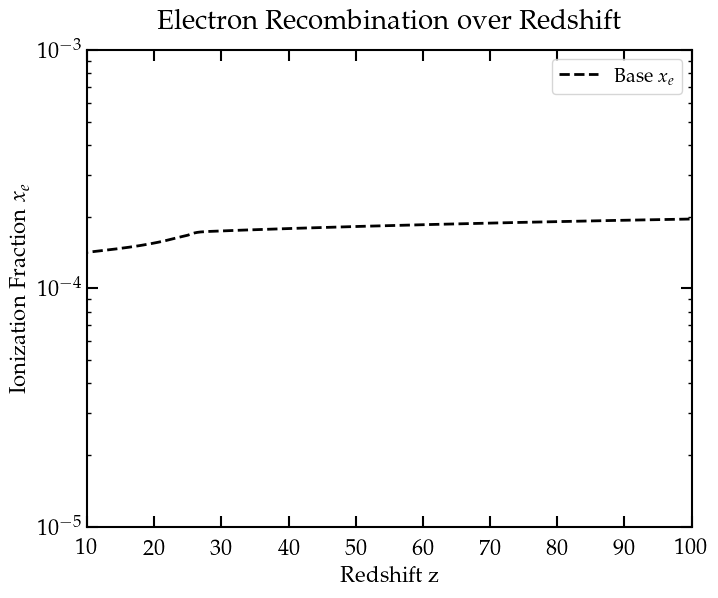

In [82]:
# Plot the results

plt.figure(figsize=(7.8, 6.2))

plt.plot(solution_base_xe.t, solution_base_xe.y[0], label=r'Base $x_e$', 
         linewidth=2, color='black', linestyle='dashed')
plt.xlabel('Redshift z')
plt.ylabel(r'Ionization Fraction $x_e$')
plt.title('Electron Recombination over Redshift')
plt.yscale('log')

plt.legend()
plt.ylim(1e-5,1e-3)
plt.xlim(10,100)
plt.show()

In [83]:
# Create an interpolating function to store 
xe_base = interp1d(solution_base_xe.t, solution_base_xe.y[0])

In [84]:
xe_base(np.array([10]))

array([0.00014176])

## 2. Base H2

In [85]:
## First define a H^- dissociation rate due to CMB photons. This suppresses H2 formation before structure formation.

def k_pd_CMB(z, m0): 
    val = ( 
        4 * (2*np.pi)**(3/2) *
        ( phys.me_eV * phys.kB * phys.T_CMB(z) )**(3/2) / 
        (phys.h_planck * phys.cs)**3 * 
        np.exp(-0.754 / phys.kB / phys.T_CMB(z)) * 
        phys.C_Hminus(T_halo(m0, z))
    )

    return val

In [86]:
# Define base H2 history function for H2 production
def dH2_dz_base (z, xH2, m0): 
    
    # Formation 
    form = - phys.C_Hminus(T_halo( m0, z)) * xe_base(z) * (1-xe_base(z)) * nH_Halo(m0_base, z)

    # Dissociation via CMB 
    pd = (1 + k_pd_CMB(z, m0) / (phys.C_H2(T_halo(m0_base, z)) * (1-xe_base(z)) * nH_Halo(m0_base, z)) )**(-1)
    
    return form * pd / (1+z) / phys.Hubble(z) 

In [87]:
dH2_dz_base (50, 1e-8, m0_base)

array([-1.40508325e-08])

In [88]:
z0

10

In [89]:
# Define redshift range of interest
z_span = (119.9, 0.2)
z_eval=np.arange(119.9,0.2,-0.1)

# Solve the ODE 
"""
Here I've used the H2 abundance in the IGM as 10^(-8) as initial condition
"""
solution_base_xH2 = solve_ivp(dH2_dz_base, z_span, np.array([1e-8]), t_eval= z_eval, rtol=1e-10, atol=1e-10, args=(m0_base,) )

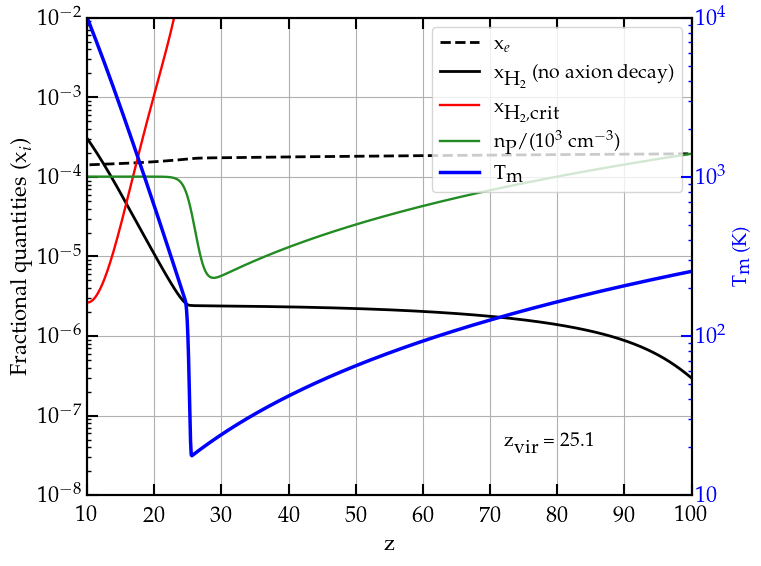

In [90]:
# Alternate version to highlight temperature history

fig, ax1 = plt.subplots(figsize=(7.8, 6.2))

# Primary axis: fractional quantities
ax1.plot(solution_base_xe.t, solution_base_xe.y[0], label=r'x$_e$', 
         linewidth=2, color='black', linestyle='dashed')

ax1.plot(solution_base_xH2.t, solution_base_xH2.y[0], label=r'x$_{\textnormal{H}_2}$ (no axion decay)', 
         linewidth=2, color='black')

ax1.plot(z_eval, crit_H2(z_eval, m0_base, 9), label=r'x$_{\textnormal{H}_2,\textnormal{crit}}$',
         color='red')

# Density plot
ax1.plot(z_eval, nH_Halo(m0_base, z_eval)/1e+3, color='forestgreen',
         label=r'n$_\textnormal{P}$/(10$^3$ cm$^{-3}$)')

# Add a text annotation
ax1.text(72, 4e-8, r'z$_\textnormal{vir}$ = 25.1', fontsize=14)

# Axis settings for ax1
ax1.set_xlabel('z')
ax1.set_ylabel(r'Fractional quantities (x$_i$)', fontsize=16)
ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_xlim(10, 100)
ax1.set_ylim(1e-8, 1e-2)
ax1.grid()
ax1.tick_params(axis='y', labelcolor='black')

# Twin axis for temperature
ax2 = ax1.twinx()

# Temperature plot (highlighted)
temp_color = 'blue'
T_vals = T_halo(m0_base, z_eval)
ax2.plot(z_eval, T_vals, label=r'T$_\textnormal{m}$', color=temp_color, linewidth=2.5)

# Axis settings for ax2
ax2.set_ylabel(r'T$_\textnormal{m}$ (K)', color=temp_color, fontsize=14)
ax2.tick_params(axis='y', which='both', colors=temp_color)
#ax2.tick_params(axis='y', color=temp_color, labelcolor=temp_color)
ax2.set_yscale('log')
ax2.set_ylim(10,1e+4)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Save and show
plt.savefig('./plots/Standard_history.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# IV. Axion decay

This section contains changes in $H_2$ history with inclusion of decaying axions. 


## 1. Photodetachment Rates 


The photo-detachment integrals are extremely slow for computational processes. In this case, redefine the photo-detachment function for easier computation. The easiest way to do this is to compute the energy integral separately, and simply multiply by some function of other parameters. 

In [91]:
# Assuming low_limit function and H_levels are defined elsewhere
def low_limit(ma):
    if ma / 2 < H_levels[0] and ma / 2 >= 0.755:
        return 0.755
    elif ma / 2 >= H_levels[0]:
        return closest_below(H_levels, ma / 2)

# Define the cross-section integral
def cs_int_func(ma):
    eth = 0.755
    ma = np.asarray(ma, dtype='float')


    def integrand(en):
        return (en - eth)**(3 / 2) / en**(5 / 2)

    results = []

    
    if np.isscalar(ma) == True: 
        e_max = ma/2
        e_min = low_limit(ma)
        result, error = quad(integrand, e_min, e_max)
        return result
    else:
        for m in ma:
            e_max = m / 2
            e_min = low_limit(m)
            result, error = quad(integrand, e_min, e_max)
            results.append(result)

    return np.array(results)



In [92]:
7.982e+5 *phys.h_planck**(3/2)* cs_int_func(np.array([0.755*5]))

array([4.33932147e-17])

In [93]:
cs_int_func(np.array([2]))

array([0.01446079])

In [94]:
# Redefine k_pd 

def k_pd (z, ma, ga):

    ma = np.asarray(ma, dtype='float')  # Convert ma to a numpy array

    # Ensure ma is 1-dimensional
    if ma.ndim == 0:  # If ma is a scalar (0-d array), convert it to 1-d
        ma = np.array([ma])

    # Define a factor to impose broadcasting if statments on axion mass and calculate axion mass dependent quantities
    fac = np.zeros_like(ma) 

    # Use masks 
    mask_zero = (ma/2 < 0.755) | (ma/2 >= phys.rydberg_energy)
    fac[mask_zero] = 0
    
    mask_one = (ma/2 >= 0.755) & (ma/2 < phys.rydberg_energy) 
    fac[mask_one] = cs_int_func(ma[mask_one]) 

    # Define a prefactor constant 
    const = (7.982e+5 * phys.cs * phys.h_planck**(3/2) * 2**(5/2) * phys.RhoCrit * phys.Omega_c * (1 + z) ** 3 *gamma_decay(ma,ga)
             / phys.Hubble(z) / ma**(5/2))

    return const*fac
    

In [95]:
k_pd(20,np.array([1,2,25,27,29]), 1e-11)

array([0.00000000e+00, 5.53765861e-11, 4.06561558e-10, 6.45612028e-12,
       0.00000000e+00])

In [96]:
k_pd(np.array([20,40,60]), 25,1e-9)

array([4.06561558e-06, 1.10921977e-05, 2.01298888e-05])

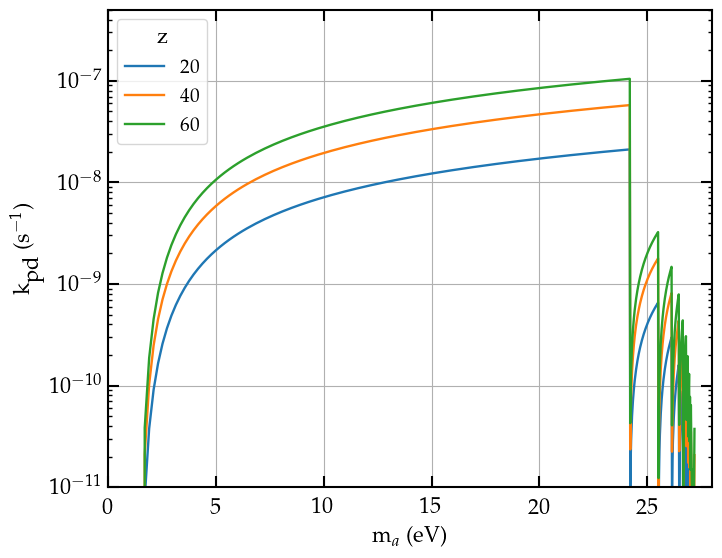

In [97]:
# print new k_pd 


list1 = 2*np.linspace(0.755,10.95,100)
list2 = 2*np.linspace(11,13.59,250)

ma_list = np.concatenate((list1,list2))

plt.figure(figsize=(7.8, 6.2))

plt.plot(ma_list, k_pd(20, ma_list, 1e-11), label='20')
plt.plot(ma_list, k_pd(40, ma_list, 1e-11), label='40')
plt.plot(ma_list, k_pd(60, ma_list, 1e-11), label='60')

plt.ylim(1e-11, 5e-7) 
plt.xlim(0,28)
plt.yscale('log')
plt.legend(title='z')

plt.xlabel(r'm$_a$ (eV)')
plt.ylabel(r'k$_{\textnormal{pd}}$ (s$^{-1}$)')

plt.grid()

plt.savefig('./plots/k_pd.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

## 2. Lyman Werner Dissociation

The Lyman Werner dissociation rates are more complex than photodetachment.

### A. Define Lyman and Werner Oscillator Strengths 

This section defines dissociation oscillator strengths as

$$ 
    f_{\alpha \dot{\alpha}} \times P_{\dot{\alpha}^{dis}}.
$$ 

In [98]:
# Import Lyman-R0
Lyman_R0 = pd.read_csv('LymanWernerDataTables/Lyman-R0.tsv',
                            sep='\t', 
                           skiprows=1)

# import Lyman-R1 
Lyman_R1 = pd.read_csv('LymanWernerDataTables/Lyman-R1.tsv', 
                           sep='\t', 
                           skiprows=1)

# Import Lyman-P1 
Lyman_P1 = pd.read_csv('LymanWernerDataTables/Lyman-P1.tsv', 
                           sep='\t', 
                           skiprows=1)

# Import Werner-R0 
Werner_R0 = pd.read_csv('LymanWernerDataTables/Werner-R0.tsv', 
                       sep='\t', 
                       skiprows=1)

# Import Werner-R1
Werner_R1 = pd.read_csv('LymanWernerDataTables/Werner-R1.tsv', 
                       sep='\t',
                       skiprows=1)

# Import Werner-Q1
Werner_Q1 = pd.read_csv('LymanWernerDataTables/Werner-Q1.tsv', 
                       sep='\t', 
                       skiprows=1)

In [99]:
# Extract energy values of each line
Lyman_R0['Energy (eV)'].values

array([11.188, 11.351, 11.51 , 11.665, 11.815, 11.961, 12.103, 12.241,
       12.375, 12.506, 12.632, 12.755, 12.875, 12.99 , 13.103, 13.211,
       13.316, 13.418, 13.516])

In [100]:
# Extract f_osc x f_diss for each line
Lyman_R0['f_total'].values

array([2.46e-09, 2.05e-09, 1.38e-07, 2.68e-06, 2.98e-05, 5.04e-04,
       9.59e-04, 6.06e-03, 8.31e-03, 1.08e-02, 8.52e-03, 8.13e-03,
       6.94e-03, 7.31e-03, 4.34e-04, 5.32e-03, 5.80e-03, 3.73e-03,
       3.69e-03])

In [101]:
# Define a lollipop plot generator
def plot_lollipop(df, label, color, zorder=1):
    x = df['Energy (eV)'].values
    y = df['f_total'].values
    plt.vlines(x, ymin=1e-10, ymax=y, color=color, linewidth=0.9, zorder=zorder)  # "stick"
    plt.scatter(x, y, color=color, s=20, label=label, zorder=zorder+1)           # "candy"

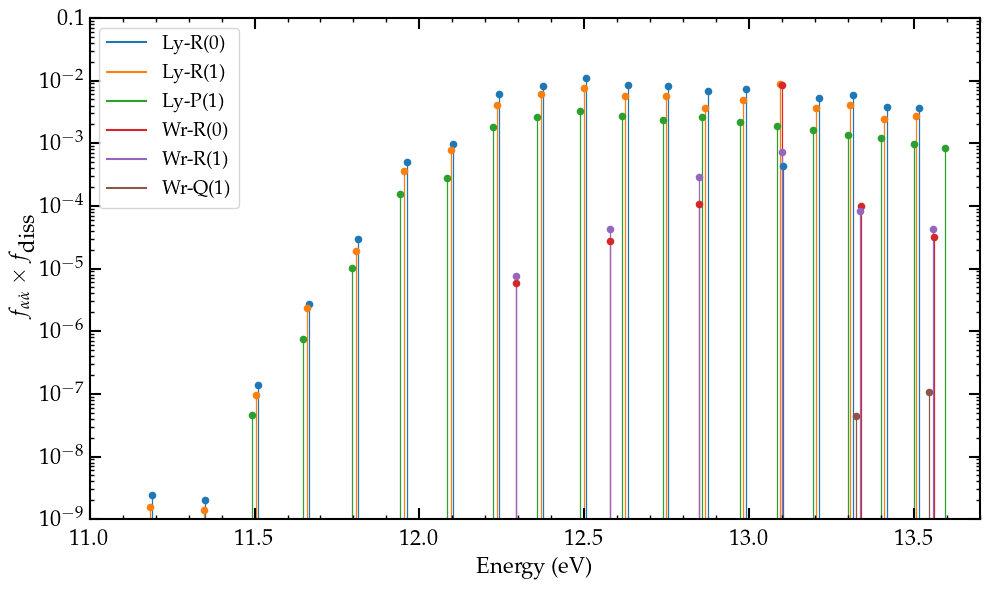

In [102]:
# Define plotting colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Start plot
plt.figure(figsize=(10, 6))
ax = plt.gca()


# Plot each set
plot_lollipop(Lyman_R0, r'Ly-R(0)', default_colors[0])
plot_lollipop(Lyman_R1, r'Ly-R(1)', default_colors[1])
plot_lollipop(Lyman_P1, r'Ly-P(1)', default_colors[2])
plot_lollipop(Werner_R0, r'Wr-R(0)', default_colors[3])
plot_lollipop(Werner_R1, r'Wr-R(1)', default_colors[4])
plot_lollipop(Werner_Q1, r'Wr-Q(1)', default_colors[5])

# Customize plot
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.set_xlim(11.0, 13.7)
ax.set_xlabel('Energy (eV)', fontsize=16)
ax.set_ylabel(r'$f_{\alpha \dot{\alpha}} \times f_{\textnormal{diss}}$', fontsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(axis='x', which='minor', labelbottom=False)


# Custom legend
custom_handles = [
    Line2D([0], [0], color=default_colors[0], lw=1.5, label=r'Ly-R(0)'),
    Line2D([0], [0], color=default_colors[1], lw=1.5, label=r'Ly-R(1)'),
    Line2D([0], [0], color=default_colors[2], lw=1.5, label=r'Ly-P(1)'),
    Line2D([0], [0], color=default_colors[3], lw=1.5, label=r'Wr-R(0)'),
    Line2D([0], [0], color=default_colors[4], lw=1.5, label=r'Wr-R(1)'),
    Line2D([0], [0], color=default_colors[5], lw=1.5, label=r'Wr-Q(1)'),
]
plt.legend(handles=custom_handles)


plt.tight_layout()

plt.savefig('plots/Lyman-Werner.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


Construct two data structures for H2: 
1. Ortho X(0,1)
2. Para X(0,0)

In [103]:
# --- File groups ---
ortho_files = [
    'LymanWernerDataTables/Lyman-R1.tsv',
    'LymanWernerDataTables/Lyman-P1.tsv',
    'LymanWernerDataTables/Werner-R1.tsv',
    'LymanWernerDataTables/Werner-Q1.tsv'
]

para_files = [
    'LymanWernerDataTables/Lyman-R0.tsv',
    'LymanWernerDataTables/Werner-R0.tsv'
]

In [104]:
def load_and_sort(file_list):
    """Load files, combine energies and f_total, and sort by energy."""
    energies = []
    f_totals = []
    
    for file in file_list:
        df = pd.read_csv(file, sep='\t', skiprows=1)
        energies.extend(df['Energy (eV)'].values)
        f_totals.extend(df['f_total'].values)
    
    energies = np.array(energies)
    f_totals = np.array(f_totals)
    
    sort_idx = np.argsort(energies)
    return energies[sort_idx], f_totals[sort_idx]

In [105]:
# --- Load datasets ---
en_LW_ortho, f_total_ortho = load_and_sort(ortho_files)
en_LW_para, f_total_para   = load_and_sort(para_files)


In [106]:
# Optional: put into DataFrames
ortho_data = pd.DataFrame({'Energy (eV)': en_LW_ortho, 'f_total': f_total_ortho})
para_data  = pd.DataFrame({'Energy (eV)': en_LW_para,  'f_total': f_total_para})


In [107]:
para_data['Energy (eV)'].values

array([11.188, 11.351, 11.51 , 11.665, 11.815, 11.961, 12.103, 12.241,
       12.293, 12.375, 12.506, 12.579, 12.632, 12.755, 12.848, 12.875,
       12.99 , 13.1  , 13.103, 13.211, 13.316, 13.338, 13.418, 13.516,
       13.559])

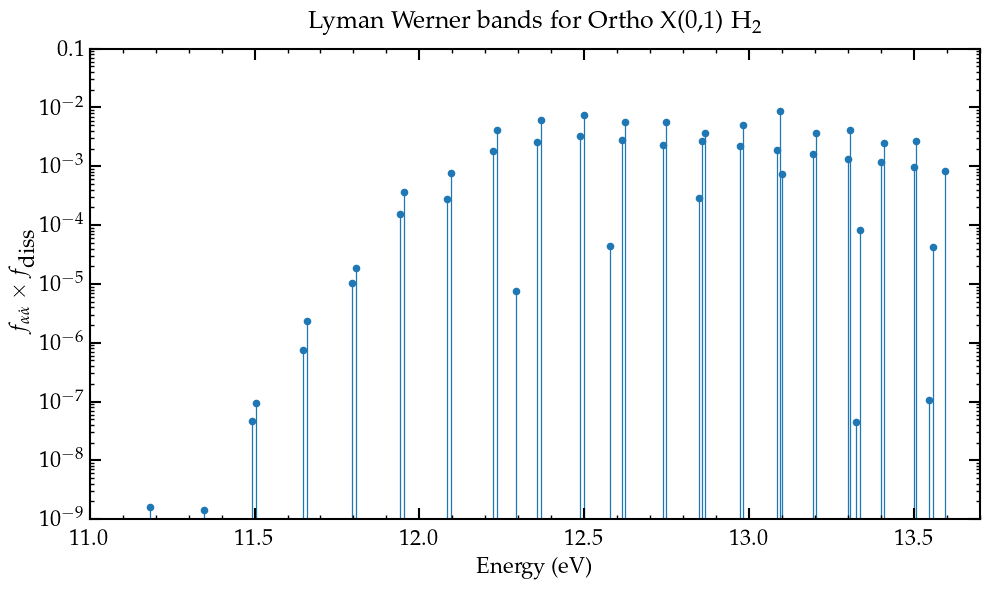

In [108]:
# Plot Ortho lines 
plt.figure(figsize=(10, 6))
ax = plt.gca()

plot_lollipop(ortho_data, r'Ortho H$_2$ transitions', default_colors[0])

# Customize plot
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.set_xlim(11.0, 13.7)
ax.set_xlabel('Energy (eV)', fontsize=16)
ax.set_ylabel(r'$f_{\alpha \dot{\alpha}} \times f_{\textnormal{diss}}$', fontsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(axis='x', which='minor', labelbottom=False)

ax.set_title(r'Lyman Werner bands for Ortho X(0,1) H$_2$', fontsize=18)

plt.tight_layout()

plt.show()

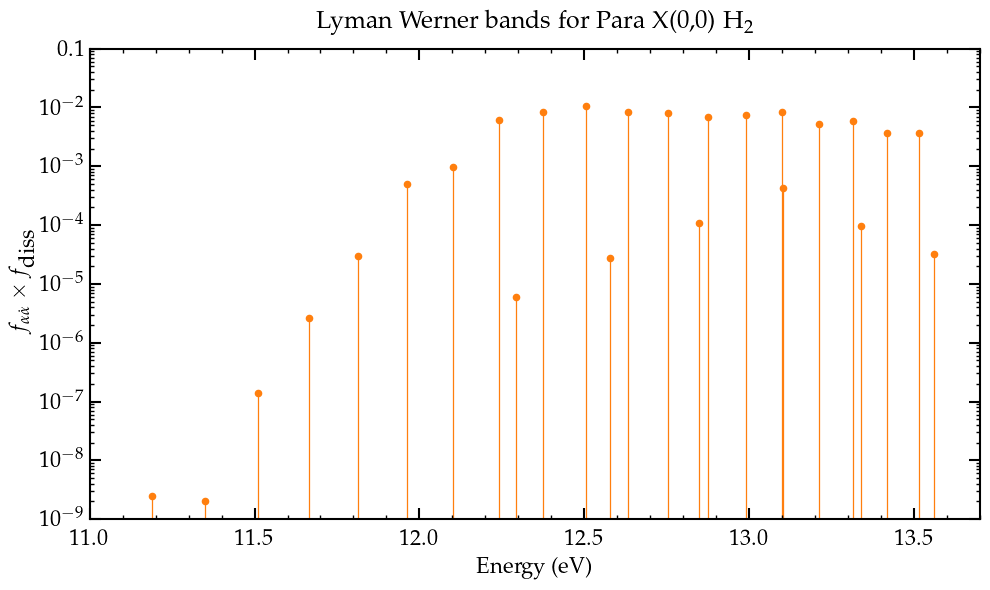

In [109]:
# Plot Para H2 lines 

plt.figure(figsize=(10, 6))
ax = plt.gca()

plot_lollipop(para_data, r'Para H$_2$ transitions', default_colors[1])

# Customize plot
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.set_xlim(11.0, 13.7)
ax.set_xlabel('Energy (eV)', fontsize=16)
ax.set_ylabel(r'$f_{\alpha \dot{\alpha}} \times f_{\textnormal{diss}}$', fontsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(axis='x', which='minor', labelbottom=False) 


ax.set_title(r'Lyman Werner bands for Para X(0,0) H$_2$', fontsize=18)
plt.tight_layout()

plt.show()

In [110]:
ortho_data['Energy (eV)'].values

array([11.169, 11.183, 11.332, 11.346, 11.491, 11.504, 11.646, 11.658,
       11.796, 11.808, 11.942, 11.954, 12.085, 12.096, 12.223, 12.234,
       12.278, 12.294, 12.357, 12.368, 12.488, 12.498, 12.564, 12.579,
       12.615, 12.624, 12.738, 12.747, 12.833, 12.847, 12.857, 12.866,
       12.973, 12.981, 13.085, 13.086, 13.092, 13.1  , 13.193, 13.202,
       13.299, 13.306, 13.323, 13.336, 13.401, 13.408, 13.499, 13.507,
       13.544, 13.556, 13.595])

In [111]:
H_levels

array([12.09394871, 12.75533653, 13.06146461, 13.2277564 , 13.32802511,
       13.39310336, 13.43772079, 13.46963538, 13.49324856, 13.51120833,
       13.52518524, 13.5362755 , 13.54522256, 13.55254506, 13.55861378,
       13.56369942, 13.5680034 , 13.57167807, 13.57484039, 13.57758137,
       13.57997265, 13.58207131])

In [112]:
closest_below(H_levels, 12)

array(nan)

### B. Function to find available Lyman Werner lines

Construct a function to find relevant Lyman Werner lines between
$$
    \text{All Ortho or Para H2 lines} \in 
    (\text{Max} (E_i^{Ly}, 11.18 \ \text{eV}), m_a / 2 ]
$$


In [113]:
""" 
Old version of the code. This one is less efficient. 
"""

def available_H2_lines_old (ma, species, 
                        H_levels = H_levels, 
                        ortho_data = ortho_data, 
                        para_data = para_data 
                       ): 

    """ 
    Find available Lyman-Werner lines for a given axion mass 

    Parameters
    ----------
    ma - axion mass (eV)
    species - str
        'ortho' or 'para' for H2 

    Return
    ---------
    array 
        H2 lines between [closest Lyman below ma/2, ma/2] 
    """

    ma = np.atleast_1d(ma)
    
    # Bounds 
    upper_bound = ma/2
    lower_bound = closest_below(H_levels, upper_bound)
    # The next line replaces numpy.nan with 0 for ma/2 < 12.09 eV. 
    lower_bound = np.nan_to_num(lower_bound, nan=0.0)

    # Find species 
    if species == 'ortho': 
        en_data = ortho_data['Energy (eV)'].values
        fosc_data = ortho_data['f_total']. values 

    elif species == 'para': 
        en_data = para_data['Energy (eV)'].values 
        fosc_data = para_data['f_total'].values

    else:
        raise ValueError("Species must be 'ortho' or 'para'.")

    dfs = []
    for m, lo, hi in zip(ma, lower_bound, upper_bound):
        mask = (en_data >= lo) & (en_data <= hi)
        if np.any(mask):
            df = pd.DataFrame({
                "ma (eV)": m,
                "Energy (eV)": en_data[mask],
                "f_total": fosc_data[mask]
            })
            dfs.append(df)

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame(columns=["ma (eV)", "Energy (eV)", "f_total"])

In [114]:
def available_H2_lines(
    ma, species,
    H_levels=H_levels,
    ortho_data=ortho_data,
    para_data=para_data
):
    """ 
    Vectorized version:
    Find available Lyman-Werner lines for many axion masses at once. 

    Parameters
    ----------
    ma : float or array-like
        Axion mass (eV)
    species : str
        'ortho' or 'para' for H2 
    H_levels : array-like
        Hydrogen Lyman transition energies (eV)
    ortho_data, para_data : DataFrame
        Contain 'Energy (eV)' and 'f_total' columns

    Returns
    -------
    DataFrame
        H2 lines between [closest Lyman below ma/2, ma/2], 
        including axion mass reference.
    """

    ma = np.atleast_1d(ma)

    # Bounds
    upper_bound = ma / 2
    lower_bound = closest_below(H_levels, upper_bound)
    lower_bound = np.nan_to_num(lower_bound, nan=0.0)
    # print(upper_bound, lower_bound)

    # Species data
    if species == "ortho":
        en_data = ortho_data["Energy (eV)"].values
        fosc_data = ortho_data["f_total"].values
    elif species == "para":
        en_data = para_data["Energy (eV)"].values
        fosc_data = para_data["f_total"].values
    else:
        raise ValueError("Species must be 'ortho' or 'para'.")

    # Precompute indices for all bounds at once
    left_indices = np.searchsorted(en_data, lower_bound, side="right")
    right_indices = np.searchsorted(en_data, upper_bound, side="right")
    # print(left_indices, right_indices)

    # Build outputs
    results = []
    for i, m in enumerate(ma):
        lo, hi = left_indices[i], right_indices[i]
        if hi > lo:  # non-empty
            df = pd.DataFrame({
                "ma (eV)": np.full(hi - lo, m),
                "Energy (eV)": en_data[lo:hi], # python slicing 
                "f_total": fosc_data[lo:hi] # python slicing 
            })
            results.append(df)

    if results:
        return pd.concat(results, ignore_index=True)
    else:
        return pd.DataFrame(columns=["ma (eV)", "Energy (eV)", "f_total"])


In [115]:
available_H2_lines (np.array([12.5*2, 12.75*2]), 'ortho')

,ma (eV),Energy (eV),f_total
0,25.0,12.096,7.670000e-04
1,25.0,12.223,1.810000e-03
2,25.0,12.234,4.110000e-03
3,25.0,12.278,2.980000e-11
4,25.0,12.294,7.570000e-06
5,25.0,12.357,2.580000e-03
6,25.0,12.368,6.100000e-03
7,25.0,12.488,3.260000e-03
8,25.0,12.498,7.500000e-03
9,25.5,12.096,7.670000e-04


In [116]:
available_H2_lines ( np.array([20,21,22,23,24,25,26,27] ), 'ortho')

,ma (eV),Energy (eV),f_total
0,23,11.169,9.050000e-10
1,23,11.183,1.580000e-09
2,23,11.332,6.410000e-10
3,23,11.346,1.410000e-09
4,23,11.491,4.610000e-08
5,24,11.169,9.050000e-10
6,24,11.183,1.580000e-09
7,24,11.332,6.410000e-10
8,24,11.346,1.410000e-09
9,24,11.491,4.610000e-08


### C. Dissociation Rate

Calculate dissociation rate by going over all Lyman Werner bands for both ortho and para H2. 

In [117]:

# Define Doppler broadening velocity 
def doppler(Tm): 
    return (phys.kB *Tm / phys.mp_eV)**(1/2) * phys.cs

# Define the power in the shielding factor denominator, call eta 
def eta (Tm, n): 
    A1 = 0.8711*np.log10(Tm) - 1.928 
    A2 = -0.9639*np.log10(Tm) + 3.892
    val = A1 * np.exp(-0.2856*np.log10(n)) + A2 
    return val 

# Define a function to calculate shielding factor 
def f_sh(Tm, ncore, rcore, xH2): 
    """ 
    Parameters: 
    Tm - matter temperature (K) 
    ncore - density at the core (cm^-3)
    rcore - radius of the core in pc 
    xH2 - H2 fraction
    """
    # xH2 = np.asarray(xH2)
    xH2 = np.clip(np.asarray(xH2), 0, None)
    
    # Define H2 column density / 5e+14 cm^2
    NH2 = 0.926 * ncore * rcore * phys.pc_to_cm * xH2 / (5e+14)

    # Define Doppler parameter / 1e+5 cm s^(-1) 
    b5 = doppler(Tm) / (1e+5)
    
    val_1 = 0.965 / ( (1 + NH2/b5)**(eta(Tm,ncore)) )
    val_2 = 0.035 *np.exp( -8.5e-4 * (1+NH2)**0.5 ) / (1 + NH2)**(0.5)

    return val_1 + val_2 

In [118]:
# Define dissociation rate 

def k_LW (z, ma, ga): 

    ma = np.atleast_1d(np.asarray(ma, dtype=float)) # Ensure ma is always a float array 

    # Call available H2 lines and check if there are any bands available. 
    ortho_data, para_data = available_H2_lines (ma, 'ortho'), available_H2_lines(ma, 'para')

    # return 0 if there are no Lyman Werner lines available. 
    if ortho_data.empty and para_data.empty:
        return np.zeros_like(ma)

    # Define coefficient 
    coeff = np.square(2 * np.pi * phys.e_charge) / phys.me / phys.cs 

    # Define decay coefficient [eV / Hz * cm / s ]
    coeff_decay = (2 * phys.cs * phys.h_planck * gamma_decay(ma, ga) / 
                  (4 * np.pi * phys.Hubble(z))
                  )

    # Number density cm^(-3) 
    number_density = phys.RhoCrit * phys.Omega_c * (1 + z) ** 3 / ma

    ###########
    # Ortho H2 
    ###########

    # Compute line contributions per row: sqrt(E) * f_total * 3/4
    ortho_data['contrib'] = (
        np.sqrt(ortho_data['Energy (eV)']) * 
        ortho_data['f_total'] * 0.75 / ortho_data['ma (eV)']**1.5
    )
    
    # Group by axion mass and sum contributions
    contrib_sum_ortho = ortho_data.groupby("ma (eV)")["contrib"].sum()

    # Map the grouped sums back to the original ma array
    contrib_array_ortho = np.array([contrib_sum_ortho.get(m, 0.0) for m in ma])

    # Final dissociation rate
    k_vals_ortho = coeff * coeff_decay * number_density * contrib_array_ortho

    ###########
    # Para H2 
    ###########

    # Compute line contributions per row: sqrt(E) * f_total * 3/4
    para_data['contrib'] = (
        np.sqrt(para_data['Energy (eV)']) * 
        para_data['f_total'] * 0.25 / para_data['ma (eV)']**1.5
    )

    # Group by axion mass and sum contributions
    contrib_sum_para = para_data.groupby("ma (eV)")["contrib"].sum()

    # Map the grouped sums back to the original ma array
    contrib_array_para = np.array([contrib_sum_para.get(m, 0.0) for m in ma])

    # Final dissociation rate
    k_vals_para = coeff * coeff_decay * number_density * contrib_array_para

    k_total = k_vals_ortho + k_vals_para
    return k_total if k_total.size > 1 else k_total.item()

    

In [119]:
k_LW (20, 25, 1e-11)

2.039506945205347e-10

In [120]:
k_LW (np.array([20,30,40]), 25, 1e-11)

array([2.03950695e-10, 3.65825665e-10, 5.56437612e-10])

In [121]:
k_LW (20, 25, np.array([1e-10, 1e-11, 1e-12]))

array([2.03950695e-08, 2.03950695e-10, 2.03950695e-12])

In [122]:
k_LW(20, np.array([24,25,26,27]), 1e-11)

array([4.56322293e-12, 2.03950695e-10, 1.26173520e-10, 6.93795684e-12])

In [123]:
k_LW(20, np.array([21,22,23,24,25,26,27]), 1e-11)

array([0.00000000e+00, 0.00000000e+00, 3.14270370e-16, 4.56322293e-12,
       2.03950695e-10, 1.26173520e-10, 6.93795684e-12])

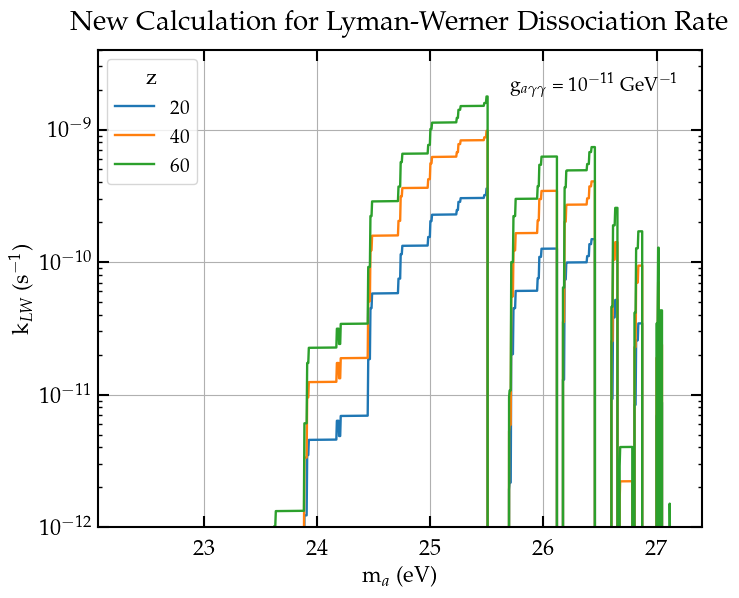

In [125]:
# Plot Lyman Werner dissociation rate 
ma_space = 2*np.linspace(11.15,13.58,1000)

# Compare different k_LW rates 
plt.figure(figsize=(7.8,6.2))

plt.plot(ma_space, k_LW(20, ma_space, 1e-11), label='20')
plt.plot(ma_space, k_LW(40, ma_space, 1e-11), label='40')
plt.plot(ma_space, k_LW(60, ma_space, 1e-11), label='60')

# plt.plot(ma_space, k_LW_approx(20, ma_space, 1e-11),
#        linestyle='dashed', color= default_colors[0], linewidth=1)
#plt.plot(ma_space, k_LW_approx(40, ma_space, 1e-11),
#         linestyle='dashed', color= default_colors[1])
#plt.plot(ma_space, k_LW_approx(60, ma_space, 1e-11),
#         linestyle='dashed', color= default_colors[2])

plt.yscale('log')

plt.legend(title='z')
plt.grid()

plt.ylim(1e-12, 4e-9)

plt.text(25.7, 2e-9, r'g$_{a \gamma \gamma}$ = 10$^{-11}$ GeV$^{-1}$', fontsize=14)
#plt.text(25.7, 1.25e-9, 'z=20', fontsize=14)

plt.title('New Calculation for Lyman-Werner Dissociation Rate')
plt.xlabel(r'm$_a$ (eV)')
plt.ylabel(r'k$_{LW}$ (s$^{-1}$)')

plt.show()

## 3. H2 History with Axion Decay 

In this section we calculate what H2 history of a typical star forming halo looks like under decaying axions.

In [127]:
# Define differential equation for x_H2

def dxH2_dz (z, xH2, m0, ma, ga): 

    ma = np.asarray(ma)
    ga = np.asarray(ga)

    # base formation term
    form = phys.C_Hminus(T_halo(m0, z)) * xe_base(z) * (1-xe_base(z)) * nH_Halo(m0, z)
    
    # photodetachment term 
    pd = 1 + (k_pd(z, ma, ga) + k_pd_CMB(z, m0) )/ (phys.C_H2(T_halo(m0, z)) * nH_Halo(m0, z)) * (1-xe_base(z))

    # LW dissociation term 
    lw = xH2*k_LW(z, ma, ga) * f_sh( T_halo(m0, z), nH_Halo(m0, z), 0.1*phys.Rvir(z, MAH(m0, z)), xH2)
    lw = np.where(k_LW(z, ma, ga) == 0, 0, lw)
    return (-1 / phys.Hubble(z) / (1+z)) * (form / pd  - lw)
    

In [128]:
dxH2_dz (20, 1e-4, 1e+9 ,25, 1e-13)

array([0.00058097])

In [129]:
dxH2_dz(np.array([1,5,10,15,20, 25, 30, 35, 40]), 1 , 1e+9, 25,1e-11)

array([ 13.62277398,  20.05219032,  25.58917898,  33.5824988 ,
        45.09867638, 179.94258628, 653.38499649, 693.68292304,
       892.27920998])

In [130]:
dxH2_dz(20, 1 , 1e+9, 25, np.array([1e-10, 1e-11, 1e-12]))

array([4.50986768e+03, 4.50986764e+01, 4.50984905e-01])

In [131]:
def stop_if_negative(t, y, *args):
    """
    Event function: triggers when xH2 = y[0] < 0.
    """
    return y[0]   # will be 0 when y[0]=0, negative if xH2 < 0

stop_if_negative.terminal = True    # stop integration if triggered
stop_if_negative.direction = -1     # only trigger when crossing downward


### Case A: Decaying axion with both LW and PD

In [132]:
# Try solving the differential equation 

# initial condition
xH20 = np.array([1e-7])

# Define MAH parameter
m0_base=5e+9 

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-0.1)

ma_1 = 25
ga_1 = 1e-13

In [133]:
%%time
solution_xH2 = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(m0_base, ma_1, ga_1), 
                         t_eval= z_eval,  
                         method='Radau',
                         rtol=1e-4, atol=1e-9
                        )

CPU times: user 4.17 s, sys: 25.3 ms, total: 4.2 s
Wall time: 4.33 s


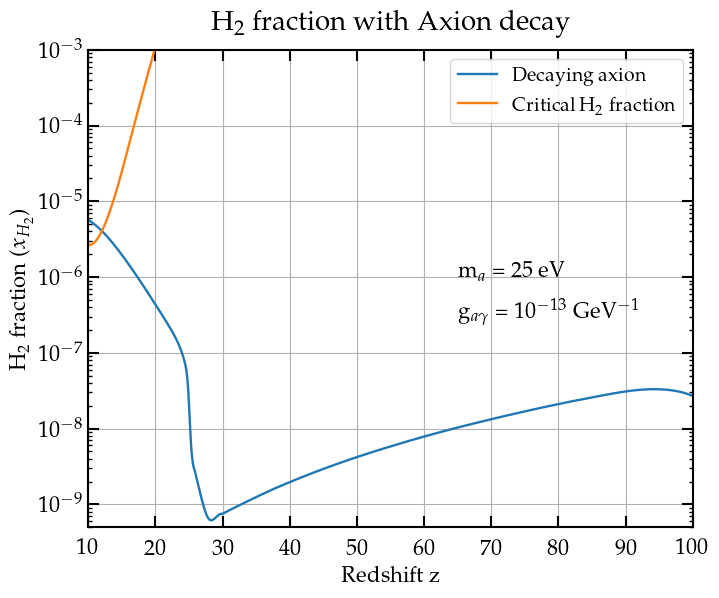

In [134]:
# Plot the results
plt.figure(figsize=(7.8, 6.2))

plt.plot(solution_xH2.t, solution_xH2.y[0], label='Decaying axion')
plt.plot(z_eval, crit_H2(z_eval, m0_base,9), label = r'Critical H$_2$ fraction' )
plt.xlabel('Redshift z')
plt.ylabel(r'H$_2$ fraction ($x_{H_2}$)')
plt.title(r'H$_2$ fraction with Axion decay')
plt.yscale('log')
plt.text(65,1e-6, r'm$_a$ = 25 eV', fontsize=16)
plt.text(65,3e-7, r'g$_{a \gamma}$ = 10$^{-13}$ GeV$^{-1}$', fontsize=16)

plt.legend()
plt.xlim(10,100)
plt.ylim(5e-10,1e-3)
plt.grid()
plt.show()

### Case B: Decaying Axion with only PD 

In [135]:
# Try a solution with just photodetachment 
ma_2 = 5
ga_2 = 1e-11

In [136]:
%%time
solution_xH2_2 = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(m0_base, ma_2, ga_2), 
                         t_eval= z_eval,  
                         rtol=1e-4, atol=1e-9,
                          vectorized=True)

CPU times: user 836 ms, sys: 15.3 ms, total: 852 ms
Wall time: 844 ms


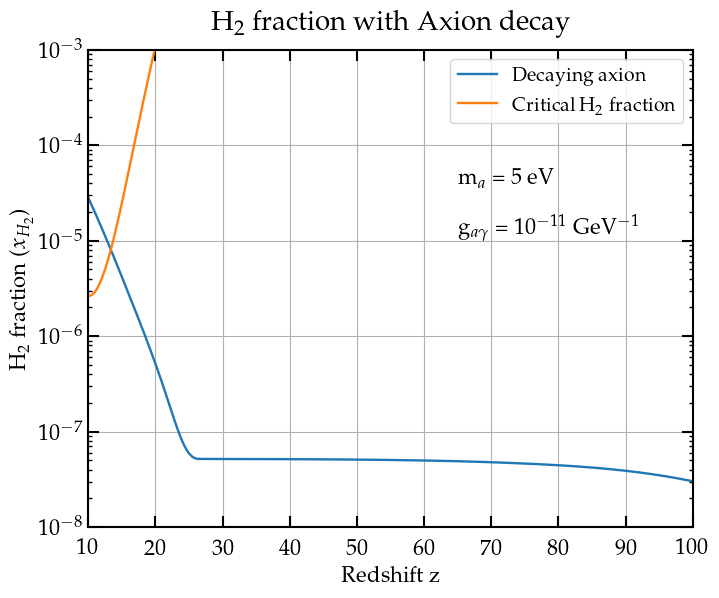

In [137]:
# Plot the results
plt.figure(figsize=(7.8, 6.2))

plt.plot(solution_xH2_2.t, solution_xH2_2.y[0], label='Decaying axion')
plt.plot(z_eval, crit_H2(z_eval, m0_base, 9), label = r'Critical H$_2$ fraction' )
plt.xlabel('Redshift z')
plt.ylabel(r'H$_2$ fraction ($x_{H_2}$)')
plt.title(r'H$_2$ fraction with Axion decay')
plt.yscale('log')
plt.text(65, 4e-5, r'm$_a$ = 5 eV', fontsize=16)
plt.text(65, 1.2e-5, r'g$_{a \gamma}$ = $10^{-11}$ GeV$^{-1}$', fontsize=16)
plt.xlim(10,100)
plt.ylim(1e-8,1e-3)
plt.legend()
plt.grid()
plt.show()

### Case C: A Small Parameter Space Scan

In this part of the code, we want to scan over a small space of axion parameters, and form the basic structure for a bigger grid. 

In [138]:
# Create a solver 

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-0.1)

ma_test = np.array([5, 10, 25, 27])
ga_test = 10**np.array([-11,-12,-13], dtype='float')
# Create an empty array to store the results 

m0_base = 5e+9

X, Y =np.meshgrid(ma_test, ga_test)

# Create an empty list to store the results
result_test = np.empty((len(ma_test), len(ga_test)), dtype=object)


In [139]:
%%time
for i,ma in enumerate(ma_test): 
    for j,ga in enumerate(ga_test):
        sol = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(m0_base, ma, ga), 
                         t_eval= z_eval,  
                         method='Radau',
                         rtol=1e-4, atol=1e-14 )
        result_test[i][j] = sol.y[0]

CPU times: user 1min 3s, sys: 466 ms, total: 1min 3s
Wall time: 1min 4s


In [140]:
print(result_test[1,2])

[1.00000000e-08 1.01199932e-08 1.02424690e-08 ... 2.09910277e-03
 2.21594760e-03 2.34993677e-03]


In [141]:
result_test.shape

(4, 3)

In [142]:
result_test[0,1]

array([1.00000000e-08, 1.01192766e-08, 1.02410036e-08, ...,
       2.02851534e-03, 2.14480594e-03, 2.27824377e-03])

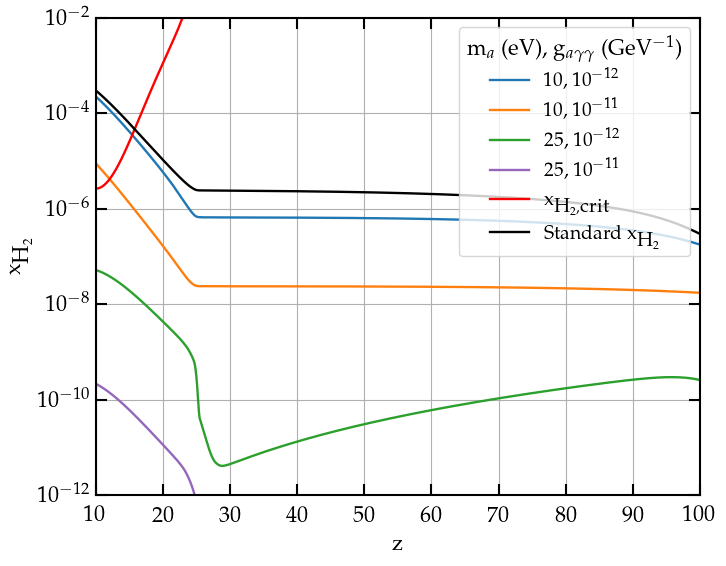

In [143]:
plt.figure(figsize=(7.8, 6.2))

plt.plot(z_eval, result_test[1,1], label=r'10, 10$^{-12}$')
plt.plot(z_eval, result_test[1,0], label=r'10, 10$^{-11}$')
plt.plot(z_eval, result_test[2,1], label=r'25, 10$^{-12}$')
plt.plot(z_eval, result_test[2,0], label=r'25, 10$^{-11}$', color=default_colors[4])

plt.plot(z_eval, crit_H2(z_eval, m0_base, 9), label = r'x$_{\textnormal{H}_2,\textnormal{crit}}$',
         color='red' )

plt.plot(solution_base_xH2.t, solution_base_xH2.y[0], label=r'Standard x$_{\textnormal{H}_2}$', 
         color='black')

plt.yscale('log')
plt.xlim(10,100)
plt.ylim(1e-12,1e-2)
plt.grid()
plt.xlabel('z')
plt.ylabel(r'x$_{\textnormal{H}_2}$')
plt.legend(title=r'm$_a$ (eV), g$_{a \gamma \gamma}$ (GeV$^{-1}$)', loc='upper right')

# plt.savefig('./plots/sample_H2.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

# V. Grid Space Run 

Compute $H_2$ histories for the fiducial model on a grid of $(m_a, g_{a \gamma \gamma})$ parameter space. 

In [144]:
# Import libraries for parallel processing
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import multiprocessing

In [152]:
# create a grid for valies 

ma_fin_1 = np.linspace(0.5,11.17,50)
ma_fin_2 = np.linspace(11.175, 13.595, 100)

ma_fin = 2*np.concatenate((ma_fin_1, ma_fin_2))

In [153]:
# Create a grid for ga gamma space
ga_fin = 10**np.linspace(-14, -9, 50)

In [154]:
# Wrap parameters in a list for tqdm
param_pairs = [(ma, ga) for ma in ma_fin for ga in ga_fin]

In [155]:
# Create z grid 
z_span = (120, 10)
z_eval= np.append(np.arange(120,10,-0.25), 10)

X, Y =np.meshgrid(ma_fin, ga_fin)

print(X.shape)

(50, 150)


### A Long Computation cells 

The next series of cells solves the initial value problem over the entire $(m_a,g_{a \gamma \gamma})$ grid. To speed up the process we will use parallel processing which cuts down computation from several hours to 10s of minutes. 

In [156]:
# Number of cores to use
n_jobs = multiprocessing.cpu_count()
print(f'Number of CPU cores available: {n_jobs}.')

Number of CPU cores available: 8.


In [157]:
# Create solver 
def solve_single_ivp (ma, ga): 
    sol = solve_ivp(
        dxH2_dz, z_span, np.array([1e-8]),
        args=(m0_base, ma, ga),
        # t_eval=z_eval,
        method='Radau',
        rtol=1e-4, atol=1e-11
    )
    return sol.y[0,-1]  # store just the x_H2 values at z=10


In [158]:
results_list = Parallel(n_jobs=-1, backend="loky")(
    delayed(solve_single_ivp)(ma, ga) for ma, ga in tqdm(param_pairs, desc="Solving IVPs")
)

Solving IVPs:   0%|          | 0/7500 [00:00<?, ?it/s]

In [159]:
results_fin = np.array(results_list, dtype=float).reshape(len(ma_fin), len(ga_fin)).T


Store the solution for ease, and call for later use

In [160]:
# Store the results in a seperate file for easier use. 

with h5py.File('./solutions/results_low_density.h5', 'w') as f: 

    print('File \'./solutions/results_low_density.h5\' created successfully.')
    
    for i, ma in enumerate(ma_fin):
        for j, ga in enumerate(ga_fin):

            # Define name for data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}'

            # Create data set and save solution 
            f.create_dataset(dataset_name, data = results_fin[j, i])

    print('Successfully exported data.')

File './solutions/results_low_density.h5' created successfully.
Successfully exported data.


In [161]:
""" 
Run this cell to simply load the solutions for the H2 fraction for each point
in the axion (ma,ga) parameter space. 

"""

# Define an empty matrix 
H2_solve_fin = np.empty( (len(ma_fin), len(ga_fin)) , dtype = object)

# import values 

with h5py.File('./solutions/results_low_density.h5', 'r') as f:
    print('File \'./solutions/results_low_density.h5\' opened succesfully.')

        
    for i, ma in enumerate(ma_fin): 
        for j, ga in enumerate(ga_fin):

            #  Name in the data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}' 

            # assign values 
            H2_solve_fin[i, j] = f[dataset_name][()]

    H2_solve_fin = np.array(H2_solve_fin, dtype=float)
    print('Succesfully imported data to variable: H2_solve_fin')


File './solutions/results_low_density.h5' opened succesfully.
Succesfully imported data to variable: H2_solve_fin


### B.  Plot Solutions

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/1340667170.py:6: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y , H2_solve_fin.T,


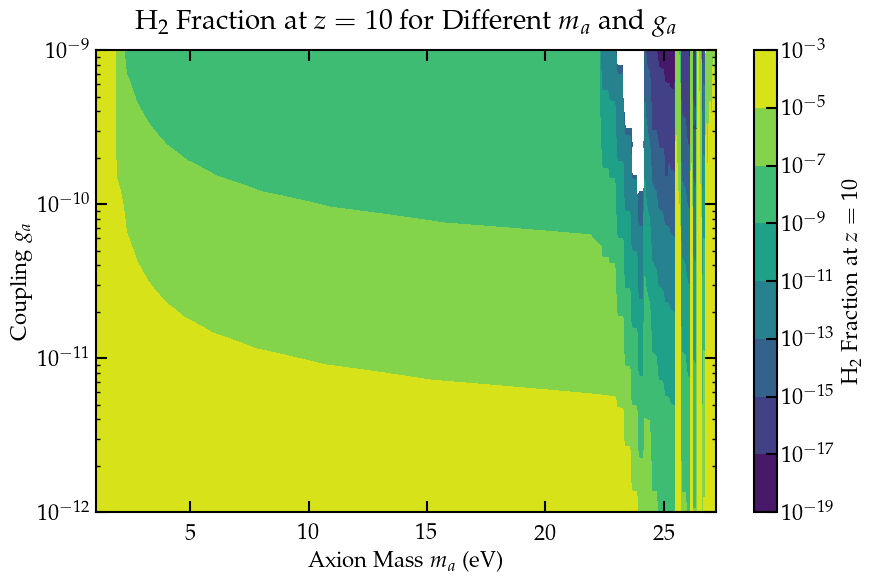

In [162]:
# Plot H2 fraction at the end of the calculation 
# Plotting the contour
plt.figure(figsize=(10, 6))
ax = plt.gca()

contour = plt.contourf(X, Y , H2_solve_fin.T, 
                       norm=LogNorm(),
                       levels=50, 
                       cmap="viridis")

cbar = plt.colorbar(contour)

ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"Axion Mass $m_a$ (eV)")
plt.ylabel(r"Coupling $g_a$")
plt.title(r"H$_2$ Fraction at $z=10$ for Different $m_a$ and $g_a$")

plt.ylim(1e-12,1e-9)
plt.show()

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/1930776797.py:6: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y , H2_solve_fin.T,


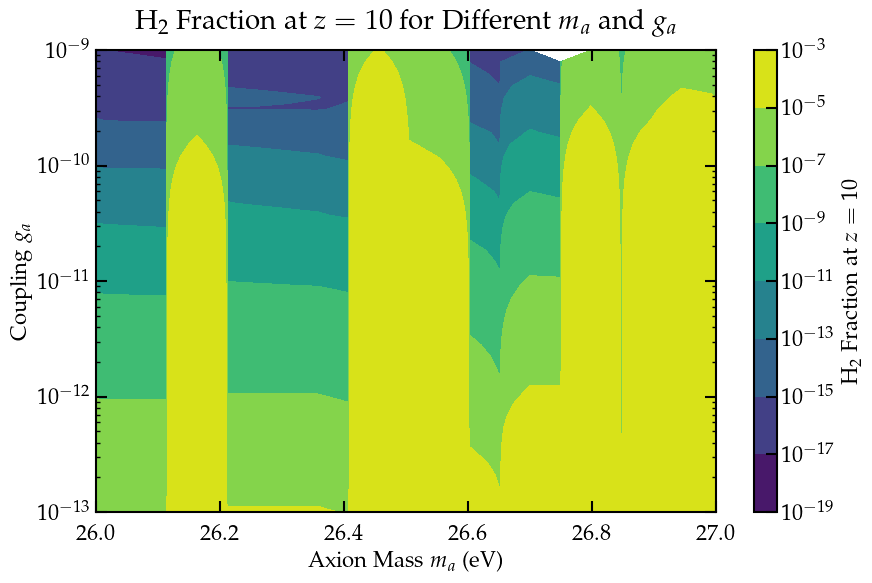

In [163]:
# Plot H2 fraction at the end of the calculation 
# Plotting the contour
plt.figure(figsize=(10, 6))
ax = plt.gca()

contour = plt.contourf(X, Y , H2_solve_fin.T, 
                       norm=LogNorm(),
                       levels=50, 
                       cmap="viridis")

cbar = plt.colorbar(contour)

ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"Axion Mass $m_a$ (eV)")
plt.ylabel(r"Coupling $g_a$")
plt.title(r"H$_2$ Fraction at $z=10$ for Different $m_a$ and $g_a$")

plt.ylim(1e-13,1e-9)
plt.xlim(26, 27)
plt.show()

In [242]:
# Filter axions that produce atomic cooling halos
DCBH_results = np.zeros((len(ga_fin), len(ma_fin)))
DCBH_results_ff = np.zeros((len(ga_fin), len(ma_fin)))
# Get Boolean answers for exclusion region 
DCBH_results = H2_solve_fin.T < crit_H2(10, 5e+9, 9)
DCBH_results_ff = H2_solve_fin.T < crit_H2(10, 5e+9, 1)
# Clip 
# DCBH_clipped = np.clip(DCBH_results.T, 1e-30, None)

In [243]:
# Mask values above 26.8 eV 
mask_ma = ma_fin >= 26.8

# Apply mask: set those entries to False
DCBH_results[:, mask_ma] = False
DCBH_results_ff[:,mask_ma] = False

### C. Import existing bounds

In [244]:
# Import Combined Bounds from multiple searches 

# Read file 
axion_bounds_data=pd.read_csv('Combined_DarkMatterAstro.txt', header=None, delimiter=' ')
axion_bounds_data = axion_bounds_data.T


In [245]:
pd.DataFrame(axion_bounds_data)
ma_bound_list = axion_bounds_data.iloc[0]
ga_bound_list = axion_bounds_data.iloc[1]

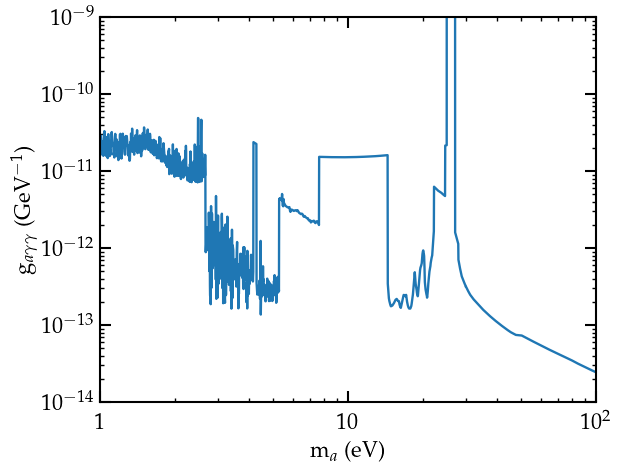

In [246]:
plt.figure(figsize=(6.4,5))
plt.loglog()

plt.plot(ma_bound_list, ga_bound_list)
plt.xlim(1,100)
plt.ylim(1e-14, 1e-9)

plt.xlabel(r'm$_a$ (eV)')
plt.ylabel(r'g$_{a \gamma \gamma}$ (GeV$^{-1}$)')

plt.show()

In [273]:
# Import CMB bound from Xu's paper 

CMB_bouds_data = pd.read_csv('/Users/yash/Desktop/Superradiance/bounds/CMB_xu_data_2.csv',header=None, delimiter=',')
CMB_bouds_data = CMB_bouds_data.apply(pd.to_numeric, errors='coerce')
CMB_bounds = CMB_bouds_data.T

In [274]:
# Convert decay life time to g_a\gamma coupling 
CMB_bounds_ga_list = np.empty_like(CMB_bounds.iloc[0])

for i,ma in enumerate(CMB_bounds.iloc[0]): 
    
    # Define decay rate in s^(-1) 
    decay_rate = CMB_bounds.iloc[1][i]

    # Define conversion 
    InvSec_to_GeV = 6.58e-25
    
    # Convert decay rate to GeV
    decay_rate = decay_rate
    
    val = 64*np.pi / (ma*1e-9)**3 / decay_rate
    val = np.sqrt(val*InvSec_to_GeV)
    CMB_bounds_ga_list[i] = val

In [275]:
# Globular clusters 
ga_globular_cluster = np.full_like(ma_fin, 5e-11, dtype=float)

In [276]:
# Create a common grid of ma values (choose sufficiently fine grid)
ma_common = np.linspace(1, 28, 500)  # Match your plot range explicitly

interp1 = interp1d(ma_bound_list, ga_bound_list, kind='linear', bounds_error=False, fill_value=np.nan)
interp2 = interp1d(CMB_bounds.iloc[0].values.flatten(), CMB_bounds_ga_list, kind='linear', bounds_error=False, fill_value=np.nan)
interp3 = interp1d(ma_fin, ga_globular_cluster, kind='linear', bounds_error=False, fill_value=np.nan)

ga1 = interp1(ma_common)  # already fine
ga2 = interp2(ma_common).flatten()   # flatten in case it’s 2D
ga3 = interp3(ma_common).flatten()

ga_stack = np.vstack([ga1, ga2, ga3])
ga_min = np.nanmin(ga_stack, axis=0)
print(ma_common.shape, ga1.shape, ga2.shape, ga3.shape, ga_min.shape)


(500,) (500,) (500,) (500,) (500,)


### D. Higher Redshift Estimate

This section estimates the axion parameters that can trigger atomic cooling halos at higher redshifts as well.

In [277]:
# Define a toy model assuming halos have reached atomic cooling limit and at the same density as our model halo. 

n_toy = 0.1 # cm^(-3)
temp_toy = 1e+4 # K 
xe_toy = 1.2e-4

In [278]:
# Based on the toy model now I want to show which axion parameters will satisfy ACH criteria at higher redshifts. 

# Define axion mass range 
# create a grid for valies 
ma_toy = 2*np.linspace(11.175, 13.595, 100)

# Create a grid for ga gamma space
ga_toy = 10**np.linspace(-15, -9, 120)

In [279]:
# Higher redshift contribution 
U,V = np.meshgrid(ma_toy, ga_toy)


In [280]:
# Define equilibrium H2 fractionA 


def xH2_eq (z, ma, ga):

    # Call photodetachment rates
    kpd = k_pd(z, ma, ga) 
    # Call LW dissociation rates 
    klw = k_LW(z, ma, ga) 

    # H2 formation term with H- channel 
    H2_form = phys.C_Hminus (temp_toy) * xe_toy * n_toy 

    # Photodetachment suppression term 
    pd_term = 1 + kpd/(phys.C_H2(temp_toy)*n_toy ) 

    # LW suppression term 
    lw_term = klw 

    # Denominator
    denom = pd_term * lw_term

    # H2 equilibrium fraction
    # xh2_eq = H2_form / pd_term / lw_term
    # Safe elementwise division
    with np.errstate(divide='ignore', invalid='ignore'):
        xh2_eq = np.where(
            np.isfinite(denom) & (denom != 0),
            H2_form / denom,
            np.nan
        )

    return xh2_eq

In [281]:
# Define different grids for different redshifts 

Toy_20 = np.zeros((len(ga_toy), len(ma_toy)) )
Toy_30 = np.zeros((len(ga_toy), len(ma_toy)) )
Toy_40 = np.zeros((len(ga_toy), len(ma_toy)) )

In [282]:
# Generate H2 fractions at different redshifts 

# Extract the value at z=10 for each (ma, ga) combination
for j, ga in enumerate(ga_toy):
    for i, ma in enumerate(ma_toy):
        try:
            # Assuming results[j, i] gives the solution array for (ma, ga)
            Toy_20[j, i] = xH2_eq (20, ma, ga).item()
            Toy_30[j, i] = xH2_eq (30, ma, ga).item()
            Toy_40[j, i] = xH2_eq (40, ma, ga).item()
        except IndexError:
            # Handle cases where results are incomplete
            print(f"Skipping invalid result at ma={ma}, ga={ga}")

In [283]:
# Define a new critical H2 fraction for simplicity. 

def crit_H2_toy (z, si): 
    
    """ 
    Here z - redshift of observation for the base halo model we are considering. 
    si - a multiplicative factor that sets critical time scale relative to free fall time scale. 
        For Hubble time/age of the universe use si = 9,
        For comparison with free fall time use si = 1.
    """
    
    # Ensure z is a numpy array
    z = np.atleast_1d(z)

    def crit_H2_func(xH2, z, si):
        # Define the inner function for fsolve
        return t_H2(xH2, n_toy, temp_toy) - si * t_ff_new(z)

    # Get the critical redshift zvir_value
    zvir_value = 50
    
    # Create a mask for valid z values
    mask = z <= zvir_value

    # Initialize an array to store the results (dtype=float to avoid issues with np.nan)
    fac = np.full(z.shape, np.nan, dtype=float)
    
    # Iterate over valid z values
    for i, valid in enumerate(mask):
        if valid:
            fac[i] = fsolve(crit_H2_func, 1e-7, args=(z[i], si))[0]  # Extract the root from fsolve

    fac[~mask] = np.nan
    
    return fac


In [284]:
# Create values for z=20 and 40. 

ACH_20 = Toy_20 < crit_H2_toy(20,9)
ACH_20_ff = Toy_20 < crit_H2_toy(20,1)

ACH_40 = Toy_40 < crit_H2_toy(40,9)
ACH_40_ff = Toy_40 < crit_H2_toy(40,1)


In [285]:
# Mask values above 26.8 eV 
mask_ma_toy = ma_toy >= 26.8

ACH_20[:, mask_ma_toy] = False
ACH_20_ff[:, mask_ma_toy] = False
ACH_40[:, mask_ma_toy] = False
ACH_40_ff[:, mask_ma_toy] = False


In [317]:
# Simple monolithic collapse
A, B = np.meshgrid(2*ma_fin_2, ga_fin)

# Vectorize k_LW to apply over arrays
k_LW_vec = np.vectorize(lambda ma, ga: k_LW(10, ma, ga))

# Vectorize k_LW to apply over arrays
k_LW_40 = np.vectorize(lambda ma, ga: k_LW(40, ma, ga))

C = k_LW_vec(A, B)
D = k_LW_40 (A,B)

C= C >= 1.39e-9
D = D>=1.39e-9

In [318]:
# Create a space for constant gamma curves 

# Create a grid for ga gamma space
ga_fin = 10**np.linspace(-14, -9, 50)

# Create a grid for ma 
ma_grid = np.linspace(1.5,27.2,100)

M, N = np.meshgrid(ma_grid, ga_fin)

Z = gamma_decay(M,N)
gamma_levels = [1e-28, 1e-26, 1e-24, 1e-22, 1e-20]

### E. Main Plot

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/4022421423.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,DCBH_results_ff,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/4022421423.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,DCBH_results,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/4022421423.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf (A, B, C,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_70146/4022421423.py:29: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in gamma_contours.collections:


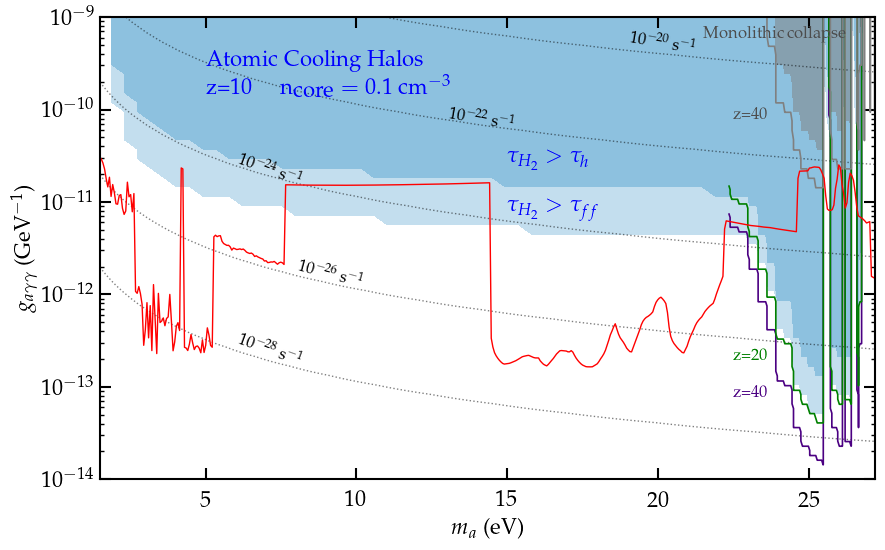

In [327]:
# Plot exclusion on ma vs ga space 
plt.figure(figsize=(10,6))
ax = plt.gca()
ax2 = plt.gca()

# ACH within free fall time 
plt.contourf(X, Y ,DCBH_results_ff, 
                       norm=LogNorm(), 
                       cmap='Blues',
                        alpha=0.4)

# ACH within a Hubble time 
plt.contourf(X, Y ,DCBH_results, 
                       norm=LogNorm(), 
                       cmap='Blues',
                        alpha=0.6)

# Monolithic case 
plt.contourf (A, B, C, 
             norm=LogNorm(), 
            cmap='gray',
            alpha=0.5)



# Add curves for constant gamma 
gamma_contours = ax.contour(M, N, Z, levels=gamma_levels, 
                            colors=[(0,0,0,0.5)], linestyles='dotted', linewidths=1)
for c in gamma_contours.collections:
    c.set_alpha(0.5)  # Make the lines lighter



# Plot analytical estimates at higher redshifts
# Plot z=40 results
z40_plt = ax2.contour(U, V ,ACH_40, 
                       levels=[0.9], colors='indigo',linewidths=1.2)


# Plot z=20 results
z20_plt = ax2.contour(U, V ,ACH_20, 
                       levels=[0.9], colors='green',linewidths=1.2)


# Plot monolithic at z=40 results 
z40_monolithic = ax2.contour(A, B, D, 
                            levels=[0.9], colors='grey',linewidths=1.2)

"""
# Add other axion bounds
plt.plot(ma_bound_list, ga_bound_list, linewidth=1, color=default_colors[3])

# Add CMB bounds 
plt.plot(CMB_bounds.iloc[0], CMB_bounds_ga_list, linewidth=1, linestyle='dashed',
         color=default_colors[3])

# Globular clusters 
plt.plot(ma_fin, ga_globular_cluster, linewidth=1, 
        linestyle='dotted', color=default_colors[3])
""" 

# Now plot the smooth combined bound
plt.plot(ma_common, ga_min, linewidth=1, color='red', label='Bounds')

ax.set_yscale('log')

plt.xlabel(r"$m_a$ (eV)")
plt.ylabel(r"$g_{a \gamma \gamma}$ (GeV$^{-1}$)")

plt.ylim(1e-14,1e-9)
plt.xlim(1.5,27.2)

# Atomic cooling labels
plt.text(5, 3e-10, r'Atomic Cooling Halos', color='blue',fontsize=16)
plt.text(5, 1.5e-10, r'z=10 \quad n$_\textnormal{core} = 0.1$ cm$^{-3}$',
         color='blue',fontsize=16)
plt.text(15, 2.75e-11, r'$\tau_{H_2} > \tau_{h}$', color='blue', fontsize=16)
plt.text(15, 8e-12, r'$\tau_{H_2} > \tau_{ff}$', color='blue', fontsize=16)

# High z labels
plt.text(22.5, 2e-13, 'z=20', fontsize=12, color='green')
plt.text(22.5, 8e-14, 'z=40', fontsize=12, color='indigo')
plt.text(22.5, 8e-11, 'z=40', fontsize=12, color=str(0.3))

# monolithic case 
plt.text(21.5, 6e-10, 'Monolithic collapse', color=str(0.3), fontsize=12)


# Add labels for constant gamma rate
plt.text(6, 1.7e-13, r"$10^{-28}\,\mathrm{s^{-1}}$", fontsize=12, rotation=-20)
plt.text(8, 1.2e-12, r"$10^{-26}\,\mathrm{s^{-1}}$", fontsize=12, rotation=-15)
plt.text(6, 1.5e-11, r"$10^{-24}\,\mathrm{s^{-1}}$", fontsize=12, rotation=-20)
plt.text(13, 6e-11, r"$10^{-22}\,\mathrm{s^{-1}}$", fontsize=12, rotation=-10)
plt.text(19, 4e-10, r"$10^{-20}\,\mathrm{s^{-1}}$", fontsize=12, rotation=-10)

plt.savefig('./plots/DCBH_low_density.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

# Rate Plots 

In this section, we plot the inverse time scales as a function of redshift for the toy halo model. Produce plot for thermal rates. Heating from dynamical heating, and proxy Hubble time scale. 
Cooling plot from standard H2, and H-$\alpha$, and changes in H2 cooling from axion decay. 

In [945]:
# Calculate the halo growth rate d(ln M / dt)

def dlnM_dt (z): 

    def mah (z): 
        return MAH(m0_base,z)

    
    deriv = derivative(mah, z, dx=1e-5)

    val = - 1 / mah(z) * deriv * (1+z) * phys.Hubble(z)
    return val

In [946]:
# Define H cooling time scale 

def t_H (xe, ncore, temp): 
    return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_13482/2521747546.py:4: RuntimeWarning: divide by zero encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_13482/2521747546.py:4: RuntimeWarning: overflow encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_13482/3207760094.py:9: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = derivative(mah, z, dx=1e-5)


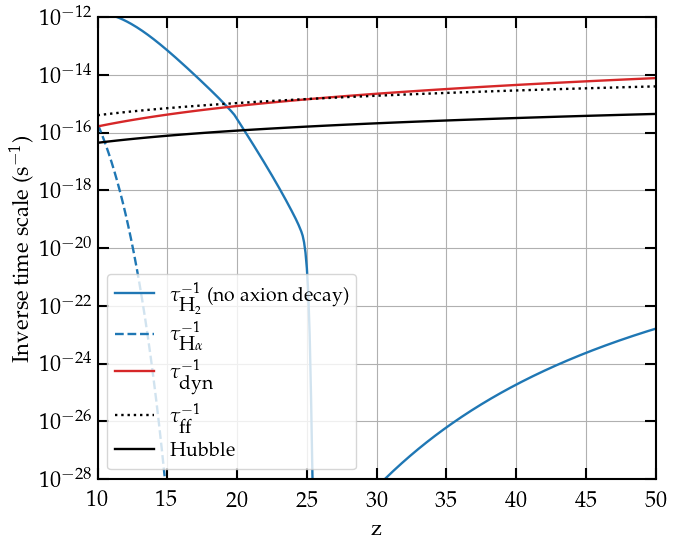

In [947]:
# Create a thermal plot for standard history. 
plt.figure(figsize=(7.2,6.0))

# Define a z space 
z_list = np.linspace(10,50,100)
z_eval=np.arange(119,0.5,-0.1)

# Show a plot for standard thermal history. 

# H2 cooling 
plt.plot(solution_base_xH2.t, 
         1/t_H2(solution_base_xH2.y[0], nH_Halo(m0_base, solution_base_xH2.t), 
                T_halo(m0_base, solution_base_xH2.t)),
        label=r'$\tau_{\textnormal{H}_2}^{-1}$ (no axion decay)', 
         color=default_colors[0])

# Add H-alpha cooling 
plt.plot(solution_base_xe.t, 
         1/t_H (3e-5, nH_Halo(m0_base, solution_base_xe.t), 
                T_halo(m0_base, solution_base_xe.t)),
        label=r'$\tau_{\textnormal{H}\alpha}^{-1}$',  color=default_colors[0], 
         linestyle='dashed')

# Add dynamical heating 
plt.plot(z_list, (2/3 * dlnM_dt(z_list)), label = r'$\tau_{\textnormal{dyn}}^{-1}$',
         color=default_colors[3])


# Plot free fall time 
plt.plot(z_list, 1/t_ff_new(z_list), color='black', 
         linestyle='dotted', label=r'$\tau_\textnormal{ff}^{-1}$')


# Add Hubble time 
plt.plot(z_list, phys.Hubble(z_list), label = r'Hubble', 
         color='black')


# Fill between t_ff and ceiling 
#plt.fill_between(z_list, phys.Hubble(z_list), 1e-12, 
#                 color='yellow', alpha=0.2, label=r'Above $t_{\rm ff}^{-1}$')

# plt.text(15.5, 1.5e-14, r'POP-III stars', color='goldenrod', fontsize=16)


plt.yscale('log')

plt.xlim(10,50)
plt.ylim(1e-28,1e-12) 

plt.xlabel('z')
plt.ylabel(r'Inverse time scale (s$^{-1}$)')

plt.grid()

plt.legend()

plt.savefig('./plots/Thermal_rates_standard.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

# Test Runs with older axion code 

In this section, I want to conduct the test runs and produce results from the older axion code. 